In [28]:
import keras
from keras.models import Sequential
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

In [13]:
train = pd.read_csv('../data/train.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
13017,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
13018,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
13019,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
13020,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
13021,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [14]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 13022/13022 [00:44<00:00, 291.91it/s]


In [15]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(13022, 224, 224, 3)

In [16]:
val = pd.read_csv('../data/val.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
5504,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5505,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5506,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5507,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5508,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [17]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 5509/5509 [00:24<00:00, 225.94it/s]


In [18]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(5509, 224, 224, 3)

In [19]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    13022
class       51
dtype: int64
image    5509
class      51
dtype: int64


In [20]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(13022, 51)
(5509, 51)


In [21]:
base_model = NASNetMobile(include_top=False, weights='imagenet')

In [22]:
print(base_model.output_shape)

(None, 7, 7, 1056)


In [23]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

separable_conv_2_reduction_righ (None, 56, 56, 11)   396         activation_9[0][0]               
__________________________________________________________________________________________________
separable_conv_2_reduction_left (None, 56, 56, 11)   220         activation_11[0][0]              
__________________________________________________________________________________________________
adjust_relu_1_stem_2 (Activatio (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_add_2_stem_1 (Add)    (None, 56, 56, 11)   0           reduction_left2_stem_1[0][0]     
                                                                 separable_conv_2_bn_reduction_rig
__________________________________________________________________________________________________
reduction_left3_stem_1 (Average (None, 56, 56, 11)   0           reduction_pad_1_stem_1[0][0]     
__________

separable_conv_2_bn_reduction_l (None, 28, 28, 22)   88          separable_conv_2_reduction_left1_
__________________________________________________________________________________________________
separable_conv_2_bn_reduction_r (None, 28, 28, 22)   88          separable_conv_2_reduction_right1
__________________________________________________________________________________________________
separable_conv_1_pad_reduction_ (None, 61, 61, 22)   0           activation_17[0][0]              
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 56, 56, 22)   0           adjust_bn_stem_2[0][0]           
__________________________________________________________________________________________________
reduction_add_1_stem_2 (Add)    (None, 28, 28, 22)   0           separable_conv_2_bn_reduction_lef
                                                                 separable_conv_2_bn_reduction_rig
__________

adjust_conv_1_0 (Conv2D)        (None, 28, 28, 22)   968         adjust_avg_pool_1_0[0][0]        
__________________________________________________________________________________________________
adjust_conv_2_0 (Conv2D)        (None, 28, 28, 22)   968         adjust_avg_pool_2_0[0][0]        
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 28, 28, 88)   0           reduction_concat_stem_2[0][0]    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 28, 28, 44)   0           adjust_conv_1_0[0][0]            
                                                                 adjust_conv_2_0[0][0]            
__________________________________________________________________________________________________
normal_conv_1_0 (Conv2D)        (None, 28, 28, 44)   3872        activation_23[0][0]              
__________

                                                                 separable_conv_2_bn_normal_right1
__________________________________________________________________________________________________
normal_add_2_0 (Add)            (None, 28, 28, 44)   0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_0 (Add)            (None, 28, 28, 44)   0           normal_left3_0[0][0]             
                                                                 adjust_bn_0[0][0]                
__________________________________________________________________________________________________
normal_add_4_0 (Add)            (None, 28, 28, 44)   0           normal_left4_0[0][0]             
                                                                 normal_right4_0[0][0]            
__________

__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 28, 28, 44)   176         separable_conv_2_normal_left1_1[0
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_2_normal_right1_1[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 28, 28, 44)   176         separable_conv_2_normal_left2_1[0
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_2_normal_right2_1[
__________________________________________________________________________________________________
normal_left3_1 (AveragePooling2 (None, 28, 28, 44)   0           normal_bn_1_1[0][0]              
__________

__________________________________________________________________________________________________
activation_51 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_right1
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_left2_
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_right2
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_left5_
__________________________________________________________________________________________________
separable_conv_2_normal_left1_2 (None, 28, 28, 44)   3036        activation_49[0][0]              
__________

__________________________________________________________________________________________________
separable_conv_1_normal_left2_3 (None, 28, 28, 44)   3036        activation_64[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_right2_ (None, 28, 28, 44)   2332        activation_66[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_left5_3 (None, 28, 28, 44)   2332        activation_68[0][0]              
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 28, 28, 44)   176         separable_conv_1_normal_left1_3[0
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_1_normal_right1_3[
__________

__________________________________________________________________________________________________
reduction_bn_1_reduce_4 (BatchN (None, 28, 28, 88)   352         reduction_conv_1_reduce_4[0][0]  
__________________________________________________________________________________________________
adjust_bn_reduce_4 (BatchNormal (None, 28, 28, 88)   352         adjust_conv_projection_reduce_4[0
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 28, 28, 88)   0           reduction_bn_1_reduce_4[0][0]    
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 28, 28, 88)   0           adjust_bn_reduce_4[0][0]         
__________________________________________________________________________________________________
separable_conv_1_pad_reduction_ (None, 31, 31, 88)   0           activation_72[0][0]              
__________

__________________________________________________________________________________________________
separable_conv_2_bn_reduction_r (None, 14, 14, 88)   352         separable_conv_2_reduction_right3
__________________________________________________________________________________________________
reduction_left4_reduce_4 (Avera (None, 14, 14, 88)   0           reduction_add_1_reduce_4[0][0]   
__________________________________________________________________________________________________
separable_conv_2_bn_reduction_l (None, 14, 14, 88)   352         separable_conv_2_reduction_left4_
__________________________________________________________________________________________________
reduction_right5_reduce_4 (MaxP (None, 14, 14, 88)   0           reduction_pad_1_reduce_4[0][0]   
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 29, 29, 264)  0           adjust_relu_1_5[0][0]            
__________

activation_90 (Activation)      (None, 14, 14, 88)   0           separable_conv_1_bn_normal_right2
__________________________________________________________________________________________________
activation_92 (Activation)      (None, 14, 14, 88)   0           separable_conv_1_bn_normal_left5_
__________________________________________________________________________________________________
separable_conv_2_normal_left1_5 (None, 14, 14, 88)   9944        activation_84[0][0]              
__________________________________________________________________________________________________
separable_conv_2_normal_right1_ (None, 14, 14, 88)   8536        activation_86[0][0]              
__________________________________________________________________________________________________
separable_conv_2_normal_left2_5 (None, 14, 14, 88)   9944        activation_88[0][0]              
__________________________________________________________________________________________________
separable_

separable_conv_1_normal_left5_6 (None, 14, 14, 88)   8536        activation_103[0][0]             
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 14, 14, 88)   352         separable_conv_1_normal_left1_6[0
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 14, 14, 88)   352         separable_conv_1_normal_right1_6[
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 14, 14, 88)   352         separable_conv_1_normal_left2_6[0
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 14, 14, 88)   352         separable_conv_1_normal_right2_6[
__________________________________________________________________________________________________
separable_

activation_107 (Activation)     (None, 14, 14, 88)   0           normal_bn_1_7[0][0]              
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 14, 14, 88)   0           adjust_bn_7[0][0]                
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 14, 14, 88)   0           adjust_bn_7[0][0]                
__________________________________________________________________________________________________
activation_113 (Activation)     (None, 14, 14, 88)   0           adjust_bn_7[0][0]                
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 14, 14, 88)   0           normal_bn_1_7[0][0]              
__________________________________________________________________________________________________
separable_

                                                                 normal_add_1_7[0][0]             
                                                                 normal_add_2_7[0][0]             
                                                                 normal_add_3_7[0][0]             
                                                                 normal_add_4_7[0][0]             
                                                                 normal_add_5_7[0][0]             
__________________________________________________________________________________________________
activation_117 (Activation)     (None, 14, 14, 528)  0           normal_concat_6[0][0]            
__________________________________________________________________________________________________
activation_118 (Activation)     (None, 14, 14, 528)  0           normal_concat_7[0][0]            
__________________________________________________________________________________________________
adjust_con

separable_conv_2_bn_normal_left (None, 14, 14, 88)   352         separable_conv_2_normal_left5_8[0
__________________________________________________________________________________________________
normal_add_1_8 (Add)            (None, 14, 14, 88)   0           separable_conv_2_bn_normal_left1_
                                                                 separable_conv_2_bn_normal_right1
__________________________________________________________________________________________________
normal_add_2_8 (Add)            (None, 14, 14, 88)   0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_8 (Add)            (None, 14, 14, 88)   0           normal_left3_8[0][0]             
                                                                 adjust_bn_8[0][0]                
__________

__________________________________________________________________________________________________
separable_conv_1_reduction_left (None, 7, 7, 176)    32560       activation_139[0][0]             
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_reduction_rig
__________________________________________________________________________________________________
separable_conv_1_bn_reduction_r (None, 7, 7, 176)    704         separable_conv_1_reduction_right3
__________________________________________________________________________________________________
separable_conv_1_bn_reduction_l (None, 7, 7, 176)    704         separable_conv_1_reduction_left4_
__________________________________________________________________________________________________
reduction_pad_1_reduce_8 (ZeroP (None, 15, 15, 176)  0           reduction_bn_1_reduce_8[0][0]    
__________

__________________________________________________________________________________________________
activation_148 (Activation)     (None, 7, 7, 176)    0           adjust_bn_9[0][0]                
__________________________________________________________________________________________________
activation_150 (Activation)     (None, 7, 7, 176)    0           normal_bn_1_9[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_left1_9 (None, 7, 7, 176)    35376       activation_142[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_right1_ (None, 7, 7, 176)    32560       activation_144[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_left2_9 (None, 7, 7, 176)    35376       activation_146[0][0]             
__________

__________________________________________________________________________________________________
activation_152 (Activation)     (None, 7, 7, 704)    0           reduction_concat_reduce_8[0][0]  
__________________________________________________________________________________________________
activation_153 (Activation)     (None, 7, 7, 1056)   0           normal_concat_9[0][0]            
__________________________________________________________________________________________________
adjust_conv_projection_10 (Conv (None, 7, 7, 176)    123904      activation_152[0][0]             
__________________________________________________________________________________________________
normal_conv_1_10 (Conv2D)       (None, 7, 7, 176)    185856      activation_153[0][0]             
__________________________________________________________________________________________________
adjust_bn_10 (BatchNormalizatio (None, 7, 7, 176)    704         adjust_conv_projection_10[0][0]  
__________

normal_add_2_10 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_10 (Add)           (None, 7, 7, 176)    0           normal_left3_10[0][0]            
                                                                 adjust_bn_10[0][0]               
__________________________________________________________________________________________________
normal_add_4_10 (Add)           (None, 7, 7, 176)    0           normal_left4_10[0][0]            
                                                                 normal_right4_10[0][0]           
__________________________________________________________________________________________________
normal_add_5_10 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left5_
          

__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 7, 7, 176)    704         separable_conv_2_normal_right1_11
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 7, 7, 176)    704         separable_conv_2_normal_left2_11[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 7, 7, 176)    704         separable_conv_2_normal_right2_11
__________________________________________________________________________________________________
normal_left3_11 (AveragePooling (None, 7, 7, 176)    0           normal_bn_1_11[0][0]             
__________________________________________________________________________________________________
normal_left4_11 (AveragePooling (None, 7, 7, 176)    0           adjust_bn_11[0][0]               
__________

__________________________________________________________________________________________________
activation_183 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_left2_
__________________________________________________________________________________________________
activation_185 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_right2
__________________________________________________________________________________________________
activation_187 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_left5_
__________________________________________________________________________________________________
separable_conv_2_normal_left1_1 (None, 7, 7, 176)    35376       activation_179[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_right1_ (None, 7, 7, 176)    32560       activation_181[0][0]             
__________

In [24]:
base_model.get_config()

{'name': 'NASNet',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'stem_conv1',
   'class_name': 'Conv2D',
   'config': {'name': 'stem_conv1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 2.0,
      'mode': 'fan_in',
      'distribution': 'normal',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_1', 0,

In [25]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2-t1)

2020-10-01 14:10:42.335195
(13022, 7, 7, 1056)
0:21:08.127404


In [26]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(13022, 7*7*1056)

In [29]:
pickle_out = open(r'E:\Thesis\HMDB\Pickle/NASNetMobile_X_train.pickle',"wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

In [30]:
pickle_in = open(r'E:\Thesis\HMDB\Pickle/NASNetMobile_X_train.pickle',"rb")
X_train = pickle.load(pickle_in)

In [31]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4-t3)

2020-10-01 15:36:33.480248
(5509, 7, 7, 1056)
0:18:22.045331


In [32]:
X_test = X_test.reshape(5509, 7*7*1056)

In [33]:
pickle_out = open(r'E:\Thesis\HMDB\Pickle/NASNetMobile_X_test.pickle',"wb")
pickle.dump(X_test, pickle_out, protocol=4)
pickle_out.close()

In [34]:
pickle_in = open(r'E:\Thesis\HMDB\Pickle/NASNetMobile_X_test.pickle',"rb")
X_test = pickle.load(pickle_in)

In [35]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13022, 51744)
(5509, 51744)
(13022, 51)
(5509, 51)


In [36]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(51744,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [37]:
model.output_shape

(None, 51)

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              52986880  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [39]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 51744),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [40]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightNASNetMobile.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [41]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [42]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-10-01 15:55:16.066068
Train on 13022 samples, validate on 5509 samples
Epoch 1/100
13022/13022 [==============================] - ETA: 5:12 - loss: 6.5636 - accuracy: 0.02 - ETA: 3:22 - loss: 11.3264 - accuracy: 0.023 - ETA: 2:51 - loss: 12.0478 - accuracy: 0.026 - ETA: 2:32 - loss: 12.4577 - accuracy: 0.025 - ETA: 2:19 - loss: 12.2733 - accuracy: 0.021 - ETA: 2:10 - loss: 12.0969 - accuracy: 0.018 - ETA: 2:03 - loss: 11.6985 - accuracy: 0.019 - ETA: 1:58 - loss: 11.2118 - accuracy: 0.021 - ETA: 1:54 - loss: 10.7839 - accuracy: 0.021 - ETA: 1:51 - loss: 10.3169 - accuracy: 0.021 - ETA: 1:47 - loss: 9.9435 - accuracy: 0.021 - ETA: 1:44 - loss: 9.5720 - accuracy: 0.02 - ETA: 1:42 - loss: 9.2428 - accuracy: 0.02 - ETA: 1:40 - loss: 8.9708 - accuracy: 0.02 - ETA: 1:38 - loss: 8.7326 - accuracy: 0.02 - ETA: 1:36 - loss: 8.4796 - accuracy: 0.02 - ETA: 1:34 - loss: 8.2571 - accuracy: 0.02 - ETA: 1:32 - loss: 8.0530 - accuracy: 0.02 - ETA: 1:30 - loss: 7.8675 - accuracy: 0.02 - ETA: 1:29 

13022/13022 [==============================] - ETA: 1:39 - loss: 3.7798 - accuracy: 0.03 - ETA: 1:33 - loss: 3.8279 - accuracy: 0.04 - ETA: 1:36 - loss: 3.8596 - accuracy: 0.04 - ETA: 1:36 - loss: 3.8681 - accuracy: 0.04 - ETA: 1:34 - loss: 3.8725 - accuracy: 0.04 - ETA: 1:33 - loss: 3.8811 - accuracy: 0.04 - ETA: 1:32 - loss: 3.8859 - accuracy: 0.04 - ETA: 1:30 - loss: 3.8895 - accuracy: 0.04 - ETA: 1:31 - loss: 3.8827 - accuracy: 0.04 - ETA: 1:29 - loss: 3.8723 - accuracy: 0.04 - ETA: 1:27 - loss: 3.8677 - accuracy: 0.05 - ETA: 1:26 - loss: 3.8627 - accuracy: 0.05 - ETA: 1:25 - loss: 3.8607 - accuracy: 0.05 - ETA: 1:24 - loss: 3.8623 - accuracy: 0.05 - ETA: 1:23 - loss: 3.8535 - accuracy: 0.05 - ETA: 1:22 - loss: 3.8587 - accuracy: 0.05 - ETA: 1:21 - loss: 3.8549 - accuracy: 0.05 - ETA: 1:20 - loss: 3.8470 - accuracy: 0.05 - ETA: 1:19 - loss: 3.8487 - accuracy: 0.05 - ETA: 1:18 - loss: 3.8503 - accuracy: 0.05 - ETA: 1:17 - loss: 3.8458 - accuracy: 0.05 - ETA: 1:16 - loss: 3.8443 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 3.5610 - accuracy: 0.14 - ETA: 1:37 - loss: 3.6222 - accuracy: 0.11 - ETA: 1:38 - loss: 3.6029 - accuracy: 0.10 - ETA: 1:35 - loss: 3.5783 - accuracy: 0.12 - ETA: 1:33 - loss: 3.5790 - accuracy: 0.11 - ETA: 1:32 - loss: 3.6004 - accuracy: 0.10 - ETA: 1:33 - loss: 3.6101 - accuracy: 0.09 - ETA: 1:33 - loss: 3.6153 - accuracy: 0.09 - ETA: 1:32 - loss: 3.6039 - accuracy: 0.10 - ETA: 1:31 - loss: 3.6013 - accuracy: 0.10 - ETA: 1:29 - loss: 3.6008 - accuracy: 0.10 - ETA: 1:29 - loss: 3.5966 - accuracy: 0.10 - ETA: 1:28 - loss: 3.6011 - accuracy: 0.10 - ETA: 1:27 - loss: 3.5960 - accuracy: 0.10 - ETA: 1:25 - loss: 3.5929 - accuracy: 0.10 - ETA: 1:24 - loss: 3.5951 - accuracy: 0.10 - ETA: 1:23 - loss: 3.5915 - accuracy: 0.11 - ETA: 1:22 - loss: 3.5909 - accuracy: 0.11 - ETA: 1:21 - loss: 3.5865 - accuracy: 0.11 - ETA: 1:20 - loss: 3.5892 - accuracy: 0.11 - ETA: 1:19 - loss: 3.5889 - accuracy: 0.11 - ETA: 1:18 - loss: 3.5795 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 3.4484 - accuracy: 0.14 - ETA: 1:40 - loss: 3.4771 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3456 - accuracy: 0.14 - ETA: 1:38 - loss: 3.3578 - accuracy: 0.14 - ETA: 1:36 - loss: 3.3592 - accuracy: 0.14 - ETA: 1:35 - loss: 3.3241 - accuracy: 0.15 - ETA: 1:35 - loss: 3.3089 - accuracy: 0.15 - ETA: 1:33 - loss: 3.3096 - accuracy: 0.16 - ETA: 1:32 - loss: 3.2871 - accuracy: 0.16 - ETA: 1:30 - loss: 3.2789 - accuracy: 0.17 - ETA: 1:29 - loss: 3.2736 - accuracy: 0.17 - ETA: 1:27 - loss: 3.2608 - accuracy: 0.17 - ETA: 1:26 - loss: 3.2456 - accuracy: 0.18 - ETA: 1:25 - loss: 3.2551 - accuracy: 0.18 - ETA: 1:24 - loss: 3.2542 - accuracy: 0.18 - ETA: 1:23 - loss: 3.2623 - accuracy: 0.18 - ETA: 1:22 - loss: 3.2607 - accuracy: 0.18 - ETA: 1:21 - loss: 3.2582 - accuracy: 0.18 - ETA: 1:20 - loss: 3.2594 - accuracy: 0.18 - ETA: 1:19 - loss: 3.2575 - accuracy: 0.18 - ETA: 1:18 - loss: 3.2466 - accuracy: 0.18 - ETA: 1:17 - loss: 3.2369 - ac

13022/13022 [==============================] - ETA: 1:41 - loss: 3.2087 - accuracy: 0.13 - ETA: 1:37 - loss: 3.1072 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0856 - accuracy: 0.18 - ETA: 1:38 - loss: 3.1518 - accuracy: 0.17 - ETA: 1:36 - loss: 3.1482 - accuracy: 0.17 - ETA: 1:35 - loss: 3.1221 - accuracy: 0.18 - ETA: 1:33 - loss: 3.1407 - accuracy: 0.18 - ETA: 1:33 - loss: 3.1257 - accuracy: 0.19 - ETA: 1:32 - loss: 3.1214 - accuracy: 0.19 - ETA: 1:31 - loss: 3.1286 - accuracy: 0.19 - ETA: 1:30 - loss: 3.1387 - accuracy: 0.19 - ETA: 1:29 - loss: 3.1320 - accuracy: 0.19 - ETA: 1:27 - loss: 3.1323 - accuracy: 0.19 - ETA: 1:26 - loss: 3.1281 - accuracy: 0.19 - ETA: 1:24 - loss: 3.1347 - accuracy: 0.19 - ETA: 1:23 - loss: 3.1135 - accuracy: 0.20 - ETA: 1:22 - loss: 3.1202 - accuracy: 0.20 - ETA: 1:21 - loss: 3.1211 - accuracy: 0.20 - ETA: 1:21 - loss: 3.1236 - accuracy: 0.20 - ETA: 1:20 - loss: 3.1101 - accuracy: 0.20 - ETA: 1:19 - loss: 3.1186 - accuracy: 0.20 - ETA: 1:18 - loss: 3.1136 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 2.9885 - accuracy: 0.25 - ETA: 1:35 - loss: 3.0300 - accuracy: 0.23 - ETA: 1:34 - loss: 3.1193 - accuracy: 0.21 - ETA: 1:32 - loss: 3.0285 - accuracy: 0.23 - ETA: 1:31 - loss: 3.0680 - accuracy: 0.22 - ETA: 1:30 - loss: 3.0636 - accuracy: 0.23 - ETA: 1:29 - loss: 3.0892 - accuracy: 0.22 - ETA: 1:28 - loss: 3.0891 - accuracy: 0.22 - ETA: 1:28 - loss: 3.0823 - accuracy: 0.22 - ETA: 1:27 - loss: 3.0569 - accuracy: 0.22 - ETA: 1:26 - loss: 3.0565 - accuracy: 0.22 - ETA: 1:25 - loss: 3.0572 - accuracy: 0.22 - ETA: 1:24 - loss: 3.0603 - accuracy: 0.22 - ETA: 1:23 - loss: 3.0610 - accuracy: 0.22 - ETA: 1:23 - loss: 3.0603 - accuracy: 0.22 - ETA: 1:22 - loss: 3.0606 - accuracy: 0.22 - ETA: 1:21 - loss: 3.0647 - accuracy: 0.22 - ETA: 1:20 - loss: 3.0549 - accuracy: 0.22 - ETA: 1:19 - loss: 3.0584 - accuracy: 0.22 - ETA: 1:18 - loss: 3.0527 - accuracy: 0.22 - ETA: 1:17 - loss: 3.0505 - accuracy: 0.22 - ETA: 1:16 - loss: 3.0448 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 2.8576 - accuracy: 0.25 - ETA: 1:38 - loss: 2.8367 - accuracy: 0.27 - ETA: 1:38 - loss: 3.0628 - accuracy: 0.24 - ETA: 1:34 - loss: 3.0648 - accuracy: 0.24 - ETA: 1:33 - loss: 3.0526 - accuracy: 0.23 - ETA: 1:31 - loss: 3.0096 - accuracy: 0.24 - ETA: 1:31 - loss: 2.9818 - accuracy: 0.24 - ETA: 1:31 - loss: 2.9924 - accuracy: 0.24 - ETA: 1:30 - loss: 3.0022 - accuracy: 0.24 - ETA: 1:29 - loss: 2.9681 - accuracy: 0.25 - ETA: 1:28 - loss: 2.9845 - accuracy: 0.24 - ETA: 1:27 - loss: 2.9728 - accuracy: 0.24 - ETA: 1:25 - loss: 2.9627 - accuracy: 0.24 - ETA: 1:24 - loss: 2.9842 - accuracy: 0.24 - ETA: 1:23 - loss: 2.9764 - accuracy: 0.24 - ETA: 1:22 - loss: 2.9667 - accuracy: 0.24 - ETA: 1:21 - loss: 2.9589 - accuracy: 0.24 - ETA: 1:20 - loss: 2.9645 - accuracy: 0.24 - ETA: 1:19 - loss: 2.9707 - accuracy: 0.24 - ETA: 1:18 - loss: 2.9746 - accuracy: 0.24 - ETA: 1:17 - loss: 2.9772 - accuracy: 0.24 - ETA: 1:16 - loss: 2.9780 - ac

13022/13022 [==============================] - ETA: 1:42 - loss: 2.7268 - accuracy: 0.29 - ETA: 1:45 - loss: 2.8125 - accuracy: 0.28 - ETA: 1:42 - loss: 2.9937 - accuracy: 0.27 - ETA: 1:40 - loss: 3.0248 - accuracy: 0.25 - ETA: 1:39 - loss: 3.0093 - accuracy: 0.25 - ETA: 1:37 - loss: 2.9468 - accuracy: 0.26 - ETA: 1:36 - loss: 2.9308 - accuracy: 0.26 - ETA: 1:35 - loss: 2.9162 - accuracy: 0.26 - ETA: 1:33 - loss: 2.9060 - accuracy: 0.26 - ETA: 1:31 - loss: 2.9077 - accuracy: 0.26 - ETA: 1:30 - loss: 2.9168 - accuracy: 0.26 - ETA: 1:29 - loss: 2.9240 - accuracy: 0.25 - ETA: 1:28 - loss: 2.9219 - accuracy: 0.26 - ETA: 1:27 - loss: 2.9114 - accuracy: 0.26 - ETA: 1:26 - loss: 2.8956 - accuracy: 0.26 - ETA: 1:25 - loss: 2.8838 - accuracy: 0.26 - ETA: 1:23 - loss: 2.8716 - accuracy: 0.26 - ETA: 1:23 - loss: 2.8759 - accuracy: 0.26 - ETA: 1:21 - loss: 2.8703 - accuracy: 0.26 - ETA: 1:20 - loss: 2.8643 - accuracy: 0.26 - ETA: 1:19 - loss: 2.8604 - accuracy: 0.27 - ETA: 1:19 - loss: 2.8627 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 2.6250 - accuracy: 0.32 - ETA: 1:34 - loss: 2.7794 - accuracy: 0.26 - ETA: 1:36 - loss: 2.7709 - accuracy: 0.27 - ETA: 1:38 - loss: 2.7346 - accuracy: 0.28 - ETA: 1:36 - loss: 2.7719 - accuracy: 0.28 - ETA: 1:34 - loss: 2.7338 - accuracy: 0.29 - ETA: 1:34 - loss: 2.7290 - accuracy: 0.30 - ETA: 1:34 - loss: 2.7446 - accuracy: 0.29 - ETA: 1:32 - loss: 2.7866 - accuracy: 0.28 - ETA: 1:31 - loss: 2.7749 - accuracy: 0.28 - ETA: 1:29 - loss: 2.7871 - accuracy: 0.28 - ETA: 1:27 - loss: 2.8040 - accuracy: 0.27 - ETA: 1:26 - loss: 2.8018 - accuracy: 0.28 - ETA: 1:25 - loss: 2.7965 - accuracy: 0.28 - ETA: 1:24 - loss: 2.7909 - accuracy: 0.28 - ETA: 1:22 - loss: 2.7878 - accuracy: 0.28 - ETA: 1:21 - loss: 2.7856 - accuracy: 0.28 - ETA: 1:20 - loss: 2.7995 - accuracy: 0.27 - ETA: 1:20 - loss: 2.8022 - accuracy: 0.27 - ETA: 1:19 - loss: 2.8233 - accuracy: 0.27 - ETA: 1:18 - loss: 2.8224 - accuracy: 0.27 - ETA: 1:16 - loss: 2.8396 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 2.7127 - accuracy: 0.27 - ETA: 1:34 - loss: 2.7719 - accuracy: 0.26 - ETA: 1:32 - loss: 2.8391 - accuracy: 0.26 - ETA: 1:32 - loss: 2.8617 - accuracy: 0.26 - ETA: 1:31 - loss: 2.8366 - accuracy: 0.27 - ETA: 1:30 - loss: 2.7815 - accuracy: 0.27 - ETA: 1:28 - loss: 2.7885 - accuracy: 0.27 - ETA: 1:27 - loss: 2.7809 - accuracy: 0.28 - ETA: 1:27 - loss: 2.7955 - accuracy: 0.27 - ETA: 1:27 - loss: 2.8127 - accuracy: 0.27 - ETA: 1:27 - loss: 2.7977 - accuracy: 0.27 - ETA: 1:26 - loss: 2.7983 - accuracy: 0.27 - ETA: 1:25 - loss: 2.8058 - accuracy: 0.27 - ETA: 1:25 - loss: 2.7842 - accuracy: 0.28 - ETA: 1:24 - loss: 2.7736 - accuracy: 0.28 - ETA: 1:23 - loss: 2.7817 - accuracy: 0.28 - ETA: 1:22 - loss: 2.7611 - accuracy: 0.28 - ETA: 1:21 - loss: 2.7847 - accuracy: 0.28 - ETA: 1:20 - loss: 2.7929 - accuracy: 0.28 - ETA: 1:18 - loss: 2.7842 - accuracy: 0.28 - ETA: 1:17 - loss: 2.7845 - accuracy: 0.28 - ETA: 1:16 - loss: 2.7939 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 2.6417 - accuracy: 0.32 - ETA: 1:35 - loss: 2.6874 - accuracy: 0.30 - ETA: 1:34 - loss: 2.6988 - accuracy: 0.29 - ETA: 1:32 - loss: 2.6221 - accuracy: 0.31 - ETA: 1:31 - loss: 2.6275 - accuracy: 0.31 - ETA: 1:30 - loss: 2.6563 - accuracy: 0.29 - ETA: 1:29 - loss: 2.6568 - accuracy: 0.30 - ETA: 1:28 - loss: 2.6734 - accuracy: 0.30 - ETA: 1:27 - loss: 2.7268 - accuracy: 0.29 - ETA: 1:26 - loss: 2.7494 - accuracy: 0.28 - ETA: 1:24 - loss: 2.7463 - accuracy: 0.28 - ETA: 1:24 - loss: 2.7495 - accuracy: 0.27 - ETA: 1:23 - loss: 2.7333 - accuracy: 0.28 - ETA: 1:23 - loss: 2.7377 - accuracy: 0.28 - ETA: 1:22 - loss: 2.7312 - accuracy: 0.28 - ETA: 1:21 - loss: 2.7321 - accuracy: 0.28 - ETA: 1:21 - loss: 2.7182 - accuracy: 0.29 - ETA: 1:20 - loss: 2.7250 - accuracy: 0.28 - ETA: 1:19 - loss: 2.7167 - accuracy: 0.29 - ETA: 1:18 - loss: 2.7153 - accuracy: 0.29 - ETA: 1:17 - loss: 2.7194 - accuracy: 0.29 - ETA: 1:17 - loss: 2.7326 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 2.8079 - accuracy: 0.28 - ETA: 1:33 - loss: 2.7664 - accuracy: 0.29 - ETA: 1:34 - loss: 2.6631 - accuracy: 0.31 - ETA: 1:33 - loss: 2.7287 - accuracy: 0.29 - ETA: 1:31 - loss: 2.7132 - accuracy: 0.30 - ETA: 1:30 - loss: 2.6630 - accuracy: 0.31 - ETA: 1:29 - loss: 2.6479 - accuracy: 0.31 - ETA: 1:30 - loss: 2.6783 - accuracy: 0.30 - ETA: 1:29 - loss: 2.6737 - accuracy: 0.30 - ETA: 1:28 - loss: 2.6874 - accuracy: 0.30 - ETA: 1:27 - loss: 2.6914 - accuracy: 0.30 - ETA: 1:25 - loss: 2.7014 - accuracy: 0.30 - ETA: 1:25 - loss: 2.6898 - accuracy: 0.30 - ETA: 1:23 - loss: 2.6584 - accuracy: 0.30 - ETA: 1:23 - loss: 2.6560 - accuracy: 0.30 - ETA: 1:22 - loss: 2.6546 - accuracy: 0.31 - ETA: 1:20 - loss: 2.6598 - accuracy: 0.30 - ETA: 1:20 - loss: 2.6538 - accuracy: 0.30 - ETA: 1:19 - loss: 2.6385 - accuracy: 0.31 - ETA: 1:18 - loss: 2.6385 - accuracy: 0.31 - ETA: 1:17 - loss: 2.6384 - accuracy: 0.30 - ETA: 1:16 - loss: 2.6341 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 2.4067 - accuracy: 0.35 - ETA: 1:32 - loss: 2.4881 - accuracy: 0.34 - ETA: 1:33 - loss: 2.5405 - accuracy: 0.33 - ETA: 1:32 - loss: 2.4733 - accuracy: 0.34 - ETA: 1:33 - loss: 2.5025 - accuracy: 0.33 - ETA: 1:31 - loss: 2.5314 - accuracy: 0.33 - ETA: 1:30 - loss: 2.5167 - accuracy: 0.34 - ETA: 1:29 - loss: 2.4954 - accuracy: 0.34 - ETA: 1:29 - loss: 2.4982 - accuracy: 0.34 - ETA: 1:28 - loss: 2.4740 - accuracy: 0.35 - ETA: 1:27 - loss: 2.4851 - accuracy: 0.34 - ETA: 1:26 - loss: 2.4938 - accuracy: 0.34 - ETA: 1:25 - loss: 2.5069 - accuracy: 0.34 - ETA: 1:24 - loss: 2.5071 - accuracy: 0.34 - ETA: 1:23 - loss: 2.5197 - accuracy: 0.34 - ETA: 1:22 - loss: 2.5106 - accuracy: 0.34 - ETA: 1:21 - loss: 2.5278 - accuracy: 0.33 - ETA: 1:20 - loss: 2.5221 - accuracy: 0.34 - ETA: 1:18 - loss: 2.5308 - accuracy: 0.33 - ETA: 1:18 - loss: 2.5301 - accuracy: 0.33 - ETA: 1:17 - loss: 2.5295 - accuracy: 0.33 - ETA: 1:16 - loss: 2.5286 - ac

13022/13022 [==============================] - ETA: 1:42 - loss: 2.3286 - accuracy: 0.35 - ETA: 1:39 - loss: 2.3952 - accuracy: 0.35 - ETA: 1:38 - loss: 2.5495 - accuracy: 0.32 - ETA: 1:36 - loss: 2.5825 - accuracy: 0.32 - ETA: 1:39 - loss: 2.5891 - accuracy: 0.32 - ETA: 1:39 - loss: 2.5602 - accuracy: 0.32 - ETA: 1:37 - loss: 2.5631 - accuracy: 0.31 - ETA: 1:35 - loss: 2.5947 - accuracy: 0.31 - ETA: 1:34 - loss: 2.5798 - accuracy: 0.31 - ETA: 1:32 - loss: 2.5606 - accuracy: 0.31 - ETA: 1:31 - loss: 2.5625 - accuracy: 0.31 - ETA: 1:29 - loss: 2.5517 - accuracy: 0.31 - ETA: 1:28 - loss: 2.5446 - accuracy: 0.32 - ETA: 1:27 - loss: 2.5332 - accuracy: 0.32 - ETA: 1:26 - loss: 2.5403 - accuracy: 0.32 - ETA: 1:25 - loss: 2.5381 - accuracy: 0.32 - ETA: 1:24 - loss: 2.5296 - accuracy: 0.33 - ETA: 1:22 - loss: 2.5372 - accuracy: 0.33 - ETA: 1:22 - loss: 2.5287 - accuracy: 0.33 - ETA: 1:20 - loss: 2.5303 - accuracy: 0.32 - ETA: 1:19 - loss: 2.5331 - accuracy: 0.32 - ETA: 1:18 - loss: 2.5308 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 2.4704 - accuracy: 0.32 - ETA: 1:38 - loss: 2.4474 - accuracy: 0.34 - ETA: 1:34 - loss: 2.4408 - accuracy: 0.34 - ETA: 1:32 - loss: 2.4661 - accuracy: 0.34 - ETA: 1:30 - loss: 2.4658 - accuracy: 0.34 - ETA: 1:30 - loss: 2.4684 - accuracy: 0.35 - ETA: 1:30 - loss: 2.4420 - accuracy: 0.37 - ETA: 1:28 - loss: 2.4212 - accuracy: 0.37 - ETA: 1:27 - loss: 2.3960 - accuracy: 0.37 - ETA: 1:27 - loss: 2.4017 - accuracy: 0.37 - ETA: 1:26 - loss: 2.4123 - accuracy: 0.37 - ETA: 1:25 - loss: 2.3985 - accuracy: 0.37 - ETA: 1:24 - loss: 2.4531 - accuracy: 0.36 - ETA: 1:23 - loss: 2.4710 - accuracy: 0.36 - ETA: 1:22 - loss: 2.4694 - accuracy: 0.36 - ETA: 1:22 - loss: 2.4566 - accuracy: 0.36 - ETA: 1:21 - loss: 2.4557 - accuracy: 0.36 - ETA: 1:20 - loss: 2.4591 - accuracy: 0.36 - ETA: 1:19 - loss: 2.4720 - accuracy: 0.36 - ETA: 1:18 - loss: 2.4670 - accuracy: 0.36 - ETA: 1:17 - loss: 2.4595 - accuracy: 0.36 - ETA: 1:16 - loss: 2.4610 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 2.5165 - accuracy: 0.31 - ETA: 1:34 - loss: 2.4290 - accuracy: 0.34 - ETA: 1:33 - loss: 2.4724 - accuracy: 0.33 - ETA: 1:33 - loss: 2.4162 - accuracy: 0.35 - ETA: 1:34 - loss: 2.4218 - accuracy: 0.35 - ETA: 1:33 - loss: 2.4153 - accuracy: 0.35 - ETA: 1:30 - loss: 2.3813 - accuracy: 0.36 - ETA: 1:29 - loss: 2.3760 - accuracy: 0.36 - ETA: 1:28 - loss: 2.3798 - accuracy: 0.36 - ETA: 1:27 - loss: 2.3918 - accuracy: 0.36 - ETA: 1:27 - loss: 2.4066 - accuracy: 0.36 - ETA: 1:25 - loss: 2.3976 - accuracy: 0.36 - ETA: 1:24 - loss: 2.3794 - accuracy: 0.36 - ETA: 1:24 - loss: 2.3821 - accuracy: 0.36 - ETA: 1:23 - loss: 2.3866 - accuracy: 0.36 - ETA: 1:22 - loss: 2.3845 - accuracy: 0.36 - ETA: 1:21 - loss: 2.3878 - accuracy: 0.36 - ETA: 1:19 - loss: 2.3702 - accuracy: 0.36 - ETA: 1:18 - loss: 2.3767 - accuracy: 0.36 - ETA: 1:18 - loss: 2.3733 - accuracy: 0.36 - ETA: 1:17 - loss: 2.3790 - accuracy: 0.36 - ETA: 1:16 - loss: 2.3701 - ac

13022/13022 [==============================] - ETA: 1:42 - loss: 2.3765 - accuracy: 0.39 - ETA: 1:37 - loss: 2.3608 - accuracy: 0.41 - ETA: 1:35 - loss: 2.4148 - accuracy: 0.37 - ETA: 1:33 - loss: 2.3519 - accuracy: 0.38 - ETA: 1:32 - loss: 2.3856 - accuracy: 0.37 - ETA: 1:31 - loss: 2.4040 - accuracy: 0.36 - ETA: 1:31 - loss: 2.3589 - accuracy: 0.37 - ETA: 1:30 - loss: 2.3498 - accuracy: 0.37 - ETA: 1:29 - loss: 2.3369 - accuracy: 0.37 - ETA: 1:27 - loss: 2.3132 - accuracy: 0.38 - ETA: 1:26 - loss: 2.3213 - accuracy: 0.38 - ETA: 1:25 - loss: 2.2932 - accuracy: 0.38 - ETA: 1:25 - loss: 2.3271 - accuracy: 0.37 - ETA: 1:24 - loss: 2.3378 - accuracy: 0.37 - ETA: 1:23 - loss: 2.3440 - accuracy: 0.37 - ETA: 1:23 - loss: 2.3443 - accuracy: 0.37 - ETA: 1:22 - loss: 2.3659 - accuracy: 0.37 - ETA: 1:21 - loss: 2.3689 - accuracy: 0.36 - ETA: 1:20 - loss: 2.3524 - accuracy: 0.37 - ETA: 1:19 - loss: 2.3654 - accuracy: 0.37 - ETA: 1:18 - loss: 2.3578 - accuracy: 0.37 - ETA: 1:17 - loss: 2.3586 - ac

13022/13022 [==============================] - ETA: 1:43 - loss: 2.0607 - accuracy: 0.45 - ETA: 1:38 - loss: 2.2267 - accuracy: 0.40 - ETA: 1:36 - loss: 2.3014 - accuracy: 0.39 - ETA: 1:37 - loss: 2.2554 - accuracy: 0.39 - ETA: 1:35 - loss: 2.3318 - accuracy: 0.37 - ETA: 1:33 - loss: 2.3453 - accuracy: 0.37 - ETA: 1:32 - loss: 2.3169 - accuracy: 0.37 - ETA: 1:30 - loss: 2.3305 - accuracy: 0.37 - ETA: 1:29 - loss: 2.3674 - accuracy: 0.36 - ETA: 1:28 - loss: 2.3563 - accuracy: 0.36 - ETA: 1:27 - loss: 2.3413 - accuracy: 0.37 - ETA: 1:26 - loss: 2.3500 - accuracy: 0.37 - ETA: 1:25 - loss: 2.3530 - accuracy: 0.37 - ETA: 1:24 - loss: 2.3530 - accuracy: 0.37 - ETA: 1:23 - loss: 2.3427 - accuracy: 0.37 - ETA: 1:22 - loss: 2.3354 - accuracy: 0.37 - ETA: 1:21 - loss: 2.3393 - accuracy: 0.36 - ETA: 1:20 - loss: 2.3318 - accuracy: 0.37 - ETA: 1:19 - loss: 2.3292 - accuracy: 0.37 - ETA: 1:18 - loss: 2.3286 - accuracy: 0.37 - ETA: 1:17 - loss: 2.3275 - accuracy: 0.37 - ETA: 1:16 - loss: 2.3324 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 2.3430 - accuracy: 0.35 - ETA: 1:33 - loss: 2.4592 - accuracy: 0.34 - ETA: 1:32 - loss: 2.4661 - accuracy: 0.34 - ETA: 1:31 - loss: 2.4483 - accuracy: 0.35 - ETA: 1:33 - loss: 2.4435 - accuracy: 0.34 - ETA: 1:31 - loss: 2.4650 - accuracy: 0.33 - ETA: 1:30 - loss: 2.4040 - accuracy: 0.35 - ETA: 1:29 - loss: 2.3887 - accuracy: 0.35 - ETA: 1:29 - loss: 2.3673 - accuracy: 0.36 - ETA: 1:29 - loss: 2.3579 - accuracy: 0.36 - ETA: 1:28 - loss: 2.3399 - accuracy: 0.36 - ETA: 1:26 - loss: 2.3490 - accuracy: 0.36 - ETA: 1:25 - loss: 2.3588 - accuracy: 0.36 - ETA: 1:25 - loss: 2.3508 - accuracy: 0.36 - ETA: 1:25 - loss: 2.3510 - accuracy: 0.36 - ETA: 1:24 - loss: 2.3465 - accuracy: 0.36 - ETA: 1:22 - loss: 2.3498 - accuracy: 0.37 - ETA: 1:21 - loss: 2.3489 - accuracy: 0.36 - ETA: 1:20 - loss: 2.3470 - accuracy: 0.36 - ETA: 1:20 - loss: 2.3503 - accuracy: 0.36 - ETA: 1:18 - loss: 2.3396 - accuracy: 0.37 - ETA: 1:17 - loss: 2.3388 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 2.0997 - accuracy: 0.39 - ETA: 1:34 - loss: 2.2569 - accuracy: 0.37 - ETA: 1:33 - loss: 2.2305 - accuracy: 0.38 - ETA: 1:31 - loss: 2.3213 - accuracy: 0.38 - ETA: 1:33 - loss: 2.3229 - accuracy: 0.37 - ETA: 1:33 - loss: 2.2641 - accuracy: 0.38 - ETA: 1:33 - loss: 2.3031 - accuracy: 0.38 - ETA: 1:32 - loss: 2.2981 - accuracy: 0.38 - ETA: 1:31 - loss: 2.2795 - accuracy: 0.38 - ETA: 1:30 - loss: 2.2924 - accuracy: 0.38 - ETA: 1:29 - loss: 2.2984 - accuracy: 0.38 - ETA: 1:28 - loss: 2.2861 - accuracy: 0.38 - ETA: 1:27 - loss: 2.2810 - accuracy: 0.38 - ETA: 1:26 - loss: 2.2955 - accuracy: 0.38 - ETA: 1:25 - loss: 2.3012 - accuracy: 0.38 - ETA: 1:24 - loss: 2.2956 - accuracy: 0.38 - ETA: 1:23 - loss: 2.2982 - accuracy: 0.38 - ETA: 1:22 - loss: 2.2970 - accuracy: 0.38 - ETA: 1:21 - loss: 2.2864 - accuracy: 0.38 - ETA: 1:20 - loss: 2.2905 - accuracy: 0.39 - ETA: 1:19 - loss: 2.2941 - accuracy: 0.38 - ETA: 1:17 - loss: 2.2964 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 2.2175 - accuracy: 0.42 - ETA: 1:40 - loss: 2.3913 - accuracy: 0.35 - ETA: 1:40 - loss: 2.2837 - accuracy: 0.39 - ETA: 1:36 - loss: 2.2434 - accuracy: 0.40 - ETA: 1:35 - loss: 2.2225 - accuracy: 0.39 - ETA: 1:33 - loss: 2.2080 - accuracy: 0.39 - ETA: 1:32 - loss: 2.2854 - accuracy: 0.39 - ETA: 1:32 - loss: 2.2483 - accuracy: 0.39 - ETA: 1:31 - loss: 2.2590 - accuracy: 0.39 - ETA: 1:30 - loss: 2.2807 - accuracy: 0.38 - ETA: 1:29 - loss: 2.2649 - accuracy: 0.38 - ETA: 1:29 - loss: 2.2671 - accuracy: 0.38 - ETA: 1:27 - loss: 2.2397 - accuracy: 0.39 - ETA: 1:26 - loss: 2.2280 - accuracy: 0.39 - ETA: 1:25 - loss: 2.2158 - accuracy: 0.39 - ETA: 1:23 - loss: 2.2202 - accuracy: 0.39 - ETA: 1:22 - loss: 2.2359 - accuracy: 0.38 - ETA: 1:21 - loss: 2.2546 - accuracy: 0.38 - ETA: 1:21 - loss: 2.2407 - accuracy: 0.38 - ETA: 1:19 - loss: 2.2333 - accuracy: 0.38 - ETA: 1:18 - loss: 2.2299 - accuracy: 0.39 - ETA: 1:17 - loss: 2.2298 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 2.5911 - accuracy: 0.28 - ETA: 1:35 - loss: 2.4295 - accuracy: 0.32 - ETA: 1:36 - loss: 2.3328 - accuracy: 0.35 - ETA: 1:35 - loss: 2.2682 - accuracy: 0.37 - ETA: 1:33 - loss: 2.2807 - accuracy: 0.38 - ETA: 1:31 - loss: 2.2128 - accuracy: 0.39 - ETA: 1:30 - loss: 2.2014 - accuracy: 0.40 - ETA: 1:30 - loss: 2.1827 - accuracy: 0.40 - ETA: 1:29 - loss: 2.1921 - accuracy: 0.40 - ETA: 1:28 - loss: 2.1907 - accuracy: 0.40 - ETA: 1:27 - loss: 2.1722 - accuracy: 0.40 - ETA: 1:27 - loss: 2.1781 - accuracy: 0.41 - ETA: 1:26 - loss: 2.1728 - accuracy: 0.41 - ETA: 1:26 - loss: 2.1701 - accuracy: 0.41 - ETA: 1:24 - loss: 2.1665 - accuracy: 0.41 - ETA: 1:23 - loss: 2.1591 - accuracy: 0.41 - ETA: 1:22 - loss: 2.1786 - accuracy: 0.40 - ETA: 1:21 - loss: 2.1712 - accuracy: 0.40 - ETA: 1:20 - loss: 2.1674 - accuracy: 0.41 - ETA: 1:19 - loss: 2.1586 - accuracy: 0.41 - ETA: 1:18 - loss: 2.1529 - accuracy: 0.41 - ETA: 1:17 - loss: 2.1593 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 2.0219 - accuracy: 0.46 - ETA: 1:35 - loss: 2.1370 - accuracy: 0.42 - ETA: 1:32 - loss: 2.0804 - accuracy: 0.42 - ETA: 1:32 - loss: 2.0472 - accuracy: 0.43 - ETA: 1:31 - loss: 2.0343 - accuracy: 0.43 - ETA: 1:31 - loss: 2.0542 - accuracy: 0.42 - ETA: 1:29 - loss: 2.1191 - accuracy: 0.41 - ETA: 1:28 - loss: 2.1394 - accuracy: 0.41 - ETA: 1:27 - loss: 2.1300 - accuracy: 0.41 - ETA: 1:26 - loss: 2.1294 - accuracy: 0.41 - ETA: 1:26 - loss: 2.1329 - accuracy: 0.41 - ETA: 1:25 - loss: 2.1426 - accuracy: 0.41 - ETA: 1:24 - loss: 2.1397 - accuracy: 0.41 - ETA: 1:23 - loss: 2.1598 - accuracy: 0.40 - ETA: 1:22 - loss: 2.1442 - accuracy: 0.40 - ETA: 1:21 - loss: 2.1426 - accuracy: 0.40 - ETA: 1:20 - loss: 2.1393 - accuracy: 0.40 - ETA: 1:19 - loss: 2.1368 - accuracy: 0.40 - ETA: 1:19 - loss: 2.1378 - accuracy: 0.40 - ETA: 1:18 - loss: 2.1357 - accuracy: 0.40 - ETA: 1:17 - loss: 2.1413 - accuracy: 0.40 - ETA: 1:16 - loss: 2.1365 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 2.0962 - accuracy: 0.41 - ETA: 1:34 - loss: 2.0711 - accuracy: 0.41 - ETA: 1:38 - loss: 2.0986 - accuracy: 0.40 - ETA: 1:38 - loss: 2.0766 - accuracy: 0.41 - ETA: 1:36 - loss: 2.0967 - accuracy: 0.41 - ETA: 1:35 - loss: 2.1113 - accuracy: 0.41 - ETA: 1:34 - loss: 2.1200 - accuracy: 0.40 - ETA: 1:34 - loss: 2.0896 - accuracy: 0.41 - ETA: 1:33 - loss: 2.0747 - accuracy: 0.42 - ETA: 1:32 - loss: 2.0799 - accuracy: 0.42 - ETA: 1:31 - loss: 2.0775 - accuracy: 0.42 - ETA: 1:29 - loss: 2.0911 - accuracy: 0.42 - ETA: 1:28 - loss: 2.1045 - accuracy: 0.42 - ETA: 1:26 - loss: 2.1022 - accuracy: 0.42 - ETA: 1:25 - loss: 2.0895 - accuracy: 0.42 - ETA: 1:24 - loss: 2.0926 - accuracy: 0.42 - ETA: 1:23 - loss: 2.1030 - accuracy: 0.42 - ETA: 1:22 - loss: 2.1036 - accuracy: 0.42 - ETA: 1:21 - loss: 2.0863 - accuracy: 0.42 - ETA: 1:20 - loss: 2.0914 - accuracy: 0.42 - ETA: 1:19 - loss: 2.1029 - accuracy: 0.42 - ETA: 1:17 - loss: 2.0908 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 2.2622 - accuracy: 0.38 - ETA: 1:35 - loss: 2.0859 - accuracy: 0.41 - ETA: 1:34 - loss: 2.1498 - accuracy: 0.40 - ETA: 1:34 - loss: 2.1898 - accuracy: 0.39 - ETA: 1:34 - loss: 2.2195 - accuracy: 0.38 - ETA: 1:33 - loss: 2.1858 - accuracy: 0.39 - ETA: 1:31 - loss: 2.1913 - accuracy: 0.40 - ETA: 1:30 - loss: 2.2315 - accuracy: 0.39 - ETA: 1:29 - loss: 2.2074 - accuracy: 0.40 - ETA: 1:28 - loss: 2.2145 - accuracy: 0.40 - ETA: 1:27 - loss: 2.1891 - accuracy: 0.40 - ETA: 1:26 - loss: 2.1958 - accuracy: 0.40 - ETA: 1:25 - loss: 2.2053 - accuracy: 0.40 - ETA: 1:24 - loss: 2.1981 - accuracy: 0.40 - ETA: 1:23 - loss: 2.1846 - accuracy: 0.40 - ETA: 1:23 - loss: 2.1799 - accuracy: 0.40 - ETA: 1:22 - loss: 2.1690 - accuracy: 0.40 - ETA: 1:21 - loss: 2.1442 - accuracy: 0.41 - ETA: 1:19 - loss: 2.1479 - accuracy: 0.41 - ETA: 1:19 - loss: 2.1509 - accuracy: 0.40 - ETA: 1:18 - loss: 2.1486 - accuracy: 0.41 - ETA: 1:17 - loss: 2.1555 - ac

13022/13022 [==============================] - ETA: 1:47 - loss: 2.0423 - accuracy: 0.42 - ETA: 1:45 - loss: 2.0851 - accuracy: 0.43 - ETA: 1:42 - loss: 1.9889 - accuracy: 0.44 - ETA: 1:39 - loss: 2.0488 - accuracy: 0.43 - ETA: 1:38 - loss: 2.0475 - accuracy: 0.43 - ETA: 1:37 - loss: 2.0462 - accuracy: 0.43 - ETA: 1:37 - loss: 2.0671 - accuracy: 0.42 - ETA: 1:36 - loss: 2.0904 - accuracy: 0.42 - ETA: 1:34 - loss: 2.1025 - accuracy: 0.41 - ETA: 1:33 - loss: 2.0879 - accuracy: 0.41 - ETA: 1:32 - loss: 2.0884 - accuracy: 0.41 - ETA: 1:31 - loss: 2.0823 - accuracy: 0.41 - ETA: 1:29 - loss: 2.0655 - accuracy: 0.42 - ETA: 1:28 - loss: 2.0650 - accuracy: 0.42 - ETA: 1:27 - loss: 2.0918 - accuracy: 0.42 - ETA: 1:25 - loss: 2.0911 - accuracy: 0.41 - ETA: 1:24 - loss: 2.0822 - accuracy: 0.42 - ETA: 1:23 - loss: 2.0880 - accuracy: 0.42 - ETA: 1:22 - loss: 2.0831 - accuracy: 0.42 - ETA: 1:21 - loss: 2.0895 - accuracy: 0.42 - ETA: 1:20 - loss: 2.0934 - accuracy: 0.42 - ETA: 1:19 - loss: 2.1035 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 2.0151 - accuracy: 0.40 - ETA: 1:40 - loss: 2.1598 - accuracy: 0.38 - ETA: 1:40 - loss: 2.0394 - accuracy: 0.42 - ETA: 1:37 - loss: 2.2005 - accuracy: 0.42 - ETA: 1:35 - loss: 2.1861 - accuracy: 0.42 - ETA: 1:34 - loss: 2.1704 - accuracy: 0.42 - ETA: 1:32 - loss: 2.1561 - accuracy: 0.41 - ETA: 1:31 - loss: 2.1602 - accuracy: 0.41 - ETA: 1:29 - loss: 2.1503 - accuracy: 0.42 - ETA: 1:29 - loss: 2.1595 - accuracy: 0.41 - ETA: 1:27 - loss: 2.1283 - accuracy: 0.41 - ETA: 1:26 - loss: 2.1282 - accuracy: 0.41 - ETA: 1:25 - loss: 2.1070 - accuracy: 0.41 - ETA: 1:24 - loss: 2.1141 - accuracy: 0.41 - ETA: 1:23 - loss: 2.1104 - accuracy: 0.41 - ETA: 1:22 - loss: 2.1004 - accuracy: 0.42 - ETA: 1:20 - loss: 2.1156 - accuracy: 0.41 - ETA: 1:20 - loss: 2.1187 - accuracy: 0.41 - ETA: 1:19 - loss: 2.1184 - accuracy: 0.41 - ETA: 1:18 - loss: 2.1194 - accuracy: 0.41 - ETA: 1:16 - loss: 2.1165 - accuracy: 0.41 - ETA: 1:15 - loss: 2.1256 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 1.8274 - accuracy: 0.49 - ETA: 1:38 - loss: 1.8447 - accuracy: 0.48 - ETA: 1:35 - loss: 1.9613 - accuracy: 0.47 - ETA: 1:34 - loss: 1.9887 - accuracy: 0.47 - ETA: 1:36 - loss: 2.0157 - accuracy: 0.45 - ETA: 1:34 - loss: 2.1077 - accuracy: 0.44 - ETA: 1:32 - loss: 2.1401 - accuracy: 0.43 - ETA: 1:31 - loss: 2.1447 - accuracy: 0.43 - ETA: 1:30 - loss: 2.1453 - accuracy: 0.42 - ETA: 1:30 - loss: 2.1410 - accuracy: 0.42 - ETA: 1:29 - loss: 2.1569 - accuracy: 0.42 - ETA: 1:27 - loss: 2.1357 - accuracy: 0.43 - ETA: 1:26 - loss: 2.1175 - accuracy: 0.43 - ETA: 1:25 - loss: 2.1130 - accuracy: 0.43 - ETA: 1:25 - loss: 2.1209 - accuracy: 0.43 - ETA: 1:24 - loss: 2.1193 - accuracy: 0.43 - ETA: 1:23 - loss: 2.1229 - accuracy: 0.43 - ETA: 1:21 - loss: 2.1150 - accuracy: 0.43 - ETA: 1:20 - loss: 2.1027 - accuracy: 0.43 - ETA: 1:19 - loss: 2.1044 - accuracy: 0.43 - ETA: 1:18 - loss: 2.0972 - accuracy: 0.43 - ETA: 1:17 - loss: 2.0903 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 2.1622 - accuracy: 0.42 - ETA: 1:40 - loss: 1.9338 - accuracy: 0.46 - ETA: 1:35 - loss: 1.9654 - accuracy: 0.43 - ETA: 1:34 - loss: 1.9498 - accuracy: 0.43 - ETA: 1:33 - loss: 1.9785 - accuracy: 0.42 - ETA: 1:31 - loss: 1.9761 - accuracy: 0.42 - ETA: 1:31 - loss: 1.9603 - accuracy: 0.43 - ETA: 1:30 - loss: 1.9950 - accuracy: 0.42 - ETA: 1:29 - loss: 2.0414 - accuracy: 0.41 - ETA: 1:28 - loss: 2.0328 - accuracy: 0.41 - ETA: 1:28 - loss: 2.0239 - accuracy: 0.41 - ETA: 1:27 - loss: 2.0088 - accuracy: 0.42 - ETA: 1:26 - loss: 2.0245 - accuracy: 0.42 - ETA: 1:25 - loss: 2.0324 - accuracy: 0.42 - ETA: 1:24 - loss: 2.0385 - accuracy: 0.42 - ETA: 1:23 - loss: 2.0456 - accuracy: 0.42 - ETA: 1:23 - loss: 2.0460 - accuracy: 0.42 - ETA: 1:22 - loss: 2.0537 - accuracy: 0.41 - ETA: 1:21 - loss: 2.0496 - accuracy: 0.41 - ETA: 1:19 - loss: 2.0518 - accuracy: 0.41 - ETA: 1:18 - loss: 2.0431 - accuracy: 0.41 - ETA: 1:17 - loss: 2.0399 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 1.9484 - accuracy: 0.48 - ETA: 1:32 - loss: 1.8514 - accuracy: 0.48 - ETA: 1:32 - loss: 1.9198 - accuracy: 0.46 - ETA: 1:31 - loss: 1.9505 - accuracy: 0.45 - ETA: 1:31 - loss: 1.9262 - accuracy: 0.46 - ETA: 1:29 - loss: 1.9397 - accuracy: 0.44 - ETA: 1:28 - loss: 1.9476 - accuracy: 0.44 - ETA: 1:27 - loss: 1.9807 - accuracy: 0.44 - ETA: 1:27 - loss: 1.9833 - accuracy: 0.44 - ETA: 1:25 - loss: 1.9894 - accuracy: 0.44 - ETA: 1:24 - loss: 1.9917 - accuracy: 0.44 - ETA: 1:24 - loss: 2.0011 - accuracy: 0.44 - ETA: 1:23 - loss: 2.0149 - accuracy: 0.44 - ETA: 1:23 - loss: 2.0157 - accuracy: 0.44 - ETA: 1:22 - loss: 2.0347 - accuracy: 0.44 - ETA: 1:21 - loss: 2.0358 - accuracy: 0.44 - ETA: 1:21 - loss: 2.0515 - accuracy: 0.43 - ETA: 1:20 - loss: 2.0374 - accuracy: 0.43 - ETA: 1:19 - loss: 2.0367 - accuracy: 0.44 - ETA: 1:18 - loss: 2.0378 - accuracy: 0.44 - ETA: 1:17 - loss: 2.0420 - accuracy: 0.43 - ETA: 1:16 - loss: 2.0533 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.7365 - accuracy: 0.52 - ETA: 1:33 - loss: 1.7492 - accuracy: 0.50 - ETA: 1:32 - loss: 1.8140 - accuracy: 0.50 - ETA: 1:31 - loss: 1.9140 - accuracy: 0.47 - ETA: 1:30 - loss: 1.8757 - accuracy: 0.47 - ETA: 1:29 - loss: 1.8972 - accuracy: 0.47 - ETA: 1:28 - loss: 1.9204 - accuracy: 0.46 - ETA: 1:27 - loss: 1.8881 - accuracy: 0.47 - ETA: 1:26 - loss: 1.8935 - accuracy: 0.46 - ETA: 1:25 - loss: 1.9222 - accuracy: 0.46 - ETA: 1:24 - loss: 1.9366 - accuracy: 0.45 - ETA: 1:24 - loss: 1.9442 - accuracy: 0.45 - ETA: 1:23 - loss: 1.9396 - accuracy: 0.45 - ETA: 1:22 - loss: 1.9544 - accuracy: 0.44 - ETA: 1:21 - loss: 1.9626 - accuracy: 0.44 - ETA: 1:21 - loss: 1.9606 - accuracy: 0.44 - ETA: 1:20 - loss: 1.9700 - accuracy: 0.44 - ETA: 1:19 - loss: 1.9792 - accuracy: 0.43 - ETA: 1:18 - loss: 1.9787 - accuracy: 0.44 - ETA: 1:17 - loss: 1.9760 - accuracy: 0.44 - ETA: 1:16 - loss: 1.9742 - accuracy: 0.44 - ETA: 1:16 - loss: 1.9902 - ac

13022/13022 [==============================] - ETA: 1:39 - loss: 1.7255 - accuracy: 0.50 - ETA: 1:37 - loss: 1.8313 - accuracy: 0.47 - ETA: 1:34 - loss: 1.8530 - accuracy: 0.45 - ETA: 1:33 - loss: 1.8727 - accuracy: 0.44 - ETA: 1:31 - loss: 1.8278 - accuracy: 0.46 - ETA: 1:30 - loss: 1.8522 - accuracy: 0.46 - ETA: 1:30 - loss: 1.8716 - accuracy: 0.45 - ETA: 1:29 - loss: 1.8570 - accuracy: 0.45 - ETA: 1:28 - loss: 1.8714 - accuracy: 0.45 - ETA: 1:27 - loss: 1.8713 - accuracy: 0.45 - ETA: 1:26 - loss: 1.8808 - accuracy: 0.45 - ETA: 1:25 - loss: 1.8940 - accuracy: 0.45 - ETA: 1:24 - loss: 1.9083 - accuracy: 0.45 - ETA: 1:23 - loss: 1.9086 - accuracy: 0.44 - ETA: 1:22 - loss: 1.9156 - accuracy: 0.45 - ETA: 1:21 - loss: 1.9204 - accuracy: 0.44 - ETA: 1:20 - loss: 1.9174 - accuracy: 0.44 - ETA: 1:19 - loss: 1.9237 - accuracy: 0.44 - ETA: 1:18 - loss: 1.9319 - accuracy: 0.44 - ETA: 1:17 - loss: 1.9441 - accuracy: 0.44 - ETA: 1:16 - loss: 1.9471 - accuracy: 0.44 - ETA: 1:15 - loss: 1.9391 - ac

13022/13022 [==============================] - ETA: 1:39 - loss: 1.9023 - accuracy: 0.45 - ETA: 1:37 - loss: 1.8906 - accuracy: 0.48 - ETA: 1:34 - loss: 1.9072 - accuracy: 0.47 - ETA: 1:34 - loss: 1.8943 - accuracy: 0.49 - ETA: 1:35 - loss: 1.9199 - accuracy: 0.47 - ETA: 1:34 - loss: 1.9054 - accuracy: 0.47 - ETA: 1:34 - loss: 1.9012 - accuracy: 0.47 - ETA: 1:33 - loss: 1.8677 - accuracy: 0.48 - ETA: 1:32 - loss: 1.8538 - accuracy: 0.48 - ETA: 1:30 - loss: 1.8533 - accuracy: 0.48 - ETA: 1:29 - loss: 1.8916 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8868 - accuracy: 0.47 - ETA: 1:26 - loss: 1.9057 - accuracy: 0.46 - ETA: 1:25 - loss: 1.8816 - accuracy: 0.47 - ETA: 1:24 - loss: 1.8952 - accuracy: 0.46 - ETA: 1:23 - loss: 1.8898 - accuracy: 0.46 - ETA: 1:22 - loss: 1.8872 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8826 - accuracy: 0.47 - ETA: 1:20 - loss: 1.8891 - accuracy: 0.46 - ETA: 1:19 - loss: 1.8806 - accuracy: 0.46 - ETA: 1:18 - loss: 1.8789 - accuracy: 0.46 - ETA: 1:17 - loss: 1.8878 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.6871 - accuracy: 0.50 - ETA: 1:34 - loss: 1.8047 - accuracy: 0.45 - ETA: 1:33 - loss: 1.8638 - accuracy: 0.45 - ETA: 1:32 - loss: 1.8361 - accuracy: 0.46 - ETA: 1:30 - loss: 1.9266 - accuracy: 0.44 - ETA: 1:29 - loss: 1.9494 - accuracy: 0.45 - ETA: 1:28 - loss: 1.9480 - accuracy: 0.44 - ETA: 1:28 - loss: 1.9681 - accuracy: 0.45 - ETA: 1:28 - loss: 1.9576 - accuracy: 0.44 - ETA: 1:28 - loss: 1.9555 - accuracy: 0.45 - ETA: 1:27 - loss: 1.9392 - accuracy: 0.45 - ETA: 1:26 - loss: 1.9394 - accuracy: 0.45 - ETA: 1:25 - loss: 1.9611 - accuracy: 0.44 - ETA: 1:24 - loss: 1.9474 - accuracy: 0.45 - ETA: 1:24 - loss: 1.9476 - accuracy: 0.45 - ETA: 1:23 - loss: 1.9480 - accuracy: 0.45 - ETA: 1:22 - loss: 1.9518 - accuracy: 0.45 - ETA: 1:21 - loss: 1.9480 - accuracy: 0.45 - ETA: 1:20 - loss: 1.9458 - accuracy: 0.45 - ETA: 1:19 - loss: 1.9454 - accuracy: 0.45 - ETA: 1:18 - loss: 1.9596 - accuracy: 0.44 - ETA: 1:17 - loss: 1.9726 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 1.8999 - accuracy: 0.42 - ETA: 1:34 - loss: 2.0417 - accuracy: 0.41 - ETA: 1:33 - loss: 1.9671 - accuracy: 0.43 - ETA: 1:31 - loss: 2.0015 - accuracy: 0.42 - ETA: 1:31 - loss: 2.0172 - accuracy: 0.42 - ETA: 1:32 - loss: 2.0100 - accuracy: 0.42 - ETA: 1:31 - loss: 1.9740 - accuracy: 0.43 - ETA: 1:29 - loss: 1.9415 - accuracy: 0.44 - ETA: 1:27 - loss: 1.9410 - accuracy: 0.44 - ETA: 1:26 - loss: 1.9484 - accuracy: 0.44 - ETA: 1:26 - loss: 1.9553 - accuracy: 0.44 - ETA: 1:25 - loss: 1.9616 - accuracy: 0.44 - ETA: 1:24 - loss: 1.9493 - accuracy: 0.44 - ETA: 1:23 - loss: 1.9396 - accuracy: 0.44 - ETA: 1:22 - loss: 1.9376 - accuracy: 0.44 - ETA: 1:21 - loss: 1.9258 - accuracy: 0.45 - ETA: 1:20 - loss: 1.9274 - accuracy: 0.45 - ETA: 1:19 - loss: 1.9303 - accuracy: 0.45 - ETA: 1:18 - loss: 1.9267 - accuracy: 0.44 - ETA: 1:17 - loss: 1.9237 - accuracy: 0.44 - ETA: 1:16 - loss: 1.9191 - accuracy: 0.45 - ETA: 1:16 - loss: 1.9179 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 2.2126 - accuracy: 0.41 - ETA: 1:38 - loss: 2.1410 - accuracy: 0.43 - ETA: 1:36 - loss: 2.1128 - accuracy: 0.43 - ETA: 1:34 - loss: 2.0580 - accuracy: 0.43 - ETA: 1:32 - loss: 2.0222 - accuracy: 0.44 - ETA: 1:31 - loss: 1.9871 - accuracy: 0.45 - ETA: 1:29 - loss: 1.9672 - accuracy: 0.45 - ETA: 1:28 - loss: 1.9444 - accuracy: 0.46 - ETA: 1:27 - loss: 1.9517 - accuracy: 0.46 - ETA: 1:26 - loss: 1.9499 - accuracy: 0.45 - ETA: 1:25 - loss: 1.9299 - accuracy: 0.46 - ETA: 1:23 - loss: 1.9395 - accuracy: 0.45 - ETA: 1:22 - loss: 1.9228 - accuracy: 0.46 - ETA: 1:21 - loss: 1.9153 - accuracy: 0.46 - ETA: 1:20 - loss: 1.9143 - accuracy: 0.46 - ETA: 1:20 - loss: 1.9158 - accuracy: 0.46 - ETA: 1:19 - loss: 1.9352 - accuracy: 0.46 - ETA: 1:18 - loss: 1.9160 - accuracy: 0.46 - ETA: 1:17 - loss: 1.9269 - accuracy: 0.46 - ETA: 1:16 - loss: 1.9250 - accuracy: 0.46 - ETA: 1:15 - loss: 1.9267 - accuracy: 0.46 - ETA: 1:14 - loss: 1.9230 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.9910 - accuracy: 0.47 - ETA: 1:34 - loss: 1.8472 - accuracy: 0.49 - ETA: 1:31 - loss: 1.9637 - accuracy: 0.45 - ETA: 1:30 - loss: 2.0373 - accuracy: 0.42 - ETA: 1:30 - loss: 2.0799 - accuracy: 0.40 - ETA: 1:28 - loss: 2.0270 - accuracy: 0.42 - ETA: 1:28 - loss: 2.0404 - accuracy: 0.41 - ETA: 1:27 - loss: 2.0129 - accuracy: 0.42 - ETA: 1:26 - loss: 1.9735 - accuracy: 0.43 - ETA: 1:24 - loss: 1.9650 - accuracy: 0.43 - ETA: 1:24 - loss: 1.9587 - accuracy: 0.43 - ETA: 1:23 - loss: 1.9457 - accuracy: 0.43 - ETA: 1:22 - loss: 1.9423 - accuracy: 0.44 - ETA: 1:21 - loss: 1.9589 - accuracy: 0.43 - ETA: 1:20 - loss: 1.9711 - accuracy: 0.43 - ETA: 1:19 - loss: 1.9659 - accuracy: 0.43 - ETA: 1:18 - loss: 1.9451 - accuracy: 0.43 - ETA: 1:17 - loss: 1.9494 - accuracy: 0.43 - ETA: 1:16 - loss: 1.9445 - accuracy: 0.44 - ETA: 1:16 - loss: 1.9461 - accuracy: 0.44 - ETA: 1:15 - loss: 1.9447 - accuracy: 0.44 - ETA: 1:14 - loss: 1.9505 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.8179 - accuracy: 0.51 - ETA: 1:31 - loss: 1.8073 - accuracy: 0.49 - ETA: 1:30 - loss: 1.8694 - accuracy: 0.45 - ETA: 1:29 - loss: 1.8433 - accuracy: 0.45 - ETA: 1:28 - loss: 1.8854 - accuracy: 0.45 - ETA: 1:27 - loss: 1.8907 - accuracy: 0.45 - ETA: 1:27 - loss: 1.9348 - accuracy: 0.44 - ETA: 1:26 - loss: 1.8985 - accuracy: 0.45 - ETA: 1:25 - loss: 1.8946 - accuracy: 0.45 - ETA: 1:25 - loss: 1.8997 - accuracy: 0.44 - ETA: 1:25 - loss: 1.8932 - accuracy: 0.45 - ETA: 1:24 - loss: 1.9173 - accuracy: 0.44 - ETA: 1:24 - loss: 1.8976 - accuracy: 0.45 - ETA: 1:23 - loss: 1.8921 - accuracy: 0.45 - ETA: 1:23 - loss: 1.8858 - accuracy: 0.45 - ETA: 1:22 - loss: 1.9123 - accuracy: 0.45 - ETA: 1:21 - loss: 1.9204 - accuracy: 0.45 - ETA: 1:20 - loss: 1.9071 - accuracy: 0.45 - ETA: 1:19 - loss: 1.8991 - accuracy: 0.46 - ETA: 1:19 - loss: 1.9066 - accuracy: 0.45 - ETA: 1:18 - loss: 1.8911 - accuracy: 0.46 - ETA: 1:17 - loss: 1.8868 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.9099 - accuracy: 0.42 - ETA: 1:35 - loss: 1.9838 - accuracy: 0.41 - ETA: 1:33 - loss: 1.9684 - accuracy: 0.42 - ETA: 1:34 - loss: 1.9606 - accuracy: 0.42 - ETA: 1:32 - loss: 1.8994 - accuracy: 0.45 - ETA: 1:31 - loss: 1.8348 - accuracy: 0.46 - ETA: 1:29 - loss: 1.8276 - accuracy: 0.47 - ETA: 1:28 - loss: 1.8303 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8129 - accuracy: 0.47 - ETA: 1:26 - loss: 1.8300 - accuracy: 0.46 - ETA: 1:26 - loss: 1.8250 - accuracy: 0.47 - ETA: 1:25 - loss: 1.8155 - accuracy: 0.47 - ETA: 1:24 - loss: 1.8201 - accuracy: 0.47 - ETA: 1:23 - loss: 1.8245 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8308 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8496 - accuracy: 0.46 - ETA: 1:20 - loss: 1.8719 - accuracy: 0.46 - ETA: 1:19 - loss: 1.8738 - accuracy: 0.46 - ETA: 1:18 - loss: 1.8694 - accuracy: 0.46 - ETA: 1:17 - loss: 1.8849 - accuracy: 0.45 - ETA: 1:16 - loss: 1.8866 - accuracy: 0.45 - ETA: 1:15 - loss: 1.8811 - ac

13022/13022 [==============================] - ETA: 1:43 - loss: 2.0060 - accuracy: 0.43 - ETA: 1:45 - loss: 1.9591 - accuracy: 0.42 - ETA: 1:42 - loss: 1.9111 - accuracy: 0.44 - ETA: 1:40 - loss: 1.8975 - accuracy: 0.45 - ETA: 1:39 - loss: 1.9035 - accuracy: 0.45 - ETA: 1:38 - loss: 1.8486 - accuracy: 0.47 - ETA: 1:38 - loss: 1.8456 - accuracy: 0.46 - ETA: 1:36 - loss: 1.8821 - accuracy: 0.46 - ETA: 1:35 - loss: 1.8764 - accuracy: 0.46 - ETA: 1:33 - loss: 1.8735 - accuracy: 0.46 - ETA: 1:31 - loss: 1.8696 - accuracy: 0.46 - ETA: 1:30 - loss: 1.8673 - accuracy: 0.46 - ETA: 1:29 - loss: 1.8693 - accuracy: 0.45 - ETA: 1:27 - loss: 1.8957 - accuracy: 0.45 - ETA: 1:26 - loss: 1.8933 - accuracy: 0.45 - ETA: 1:25 - loss: 1.8875 - accuracy: 0.45 - ETA: 1:23 - loss: 1.8838 - accuracy: 0.45 - ETA: 1:22 - loss: 1.8721 - accuracy: 0.45 - ETA: 1:21 - loss: 1.8800 - accuracy: 0.45 - ETA: 1:20 - loss: 1.8857 - accuracy: 0.45 - ETA: 1:19 - loss: 1.8776 - accuracy: 0.45 - ETA: 1:18 - loss: 1.8718 - ac

13022/13022 [==============================] - ETA: 1:41 - loss: 2.0811 - accuracy: 0.39 - ETA: 1:42 - loss: 2.0906 - accuracy: 0.41 - ETA: 1:39 - loss: 1.9772 - accuracy: 0.43 - ETA: 1:36 - loss: 1.9724 - accuracy: 0.43 - ETA: 1:35 - loss: 1.9284 - accuracy: 0.44 - ETA: 1:34 - loss: 1.9871 - accuracy: 0.43 - ETA: 1:32 - loss: 1.9667 - accuracy: 0.44 - ETA: 1:31 - loss: 1.9840 - accuracy: 0.44 - ETA: 1:29 - loss: 1.9735 - accuracy: 0.44 - ETA: 1:28 - loss: 1.9665 - accuracy: 0.44 - ETA: 1:27 - loss: 1.9490 - accuracy: 0.44 - ETA: 1:26 - loss: 1.9303 - accuracy: 0.44 - ETA: 1:25 - loss: 1.9165 - accuracy: 0.45 - ETA: 1:24 - loss: 1.9066 - accuracy: 0.45 - ETA: 1:23 - loss: 1.9145 - accuracy: 0.45 - ETA: 1:22 - loss: 1.8958 - accuracy: 0.45 - ETA: 1:21 - loss: 1.8973 - accuracy: 0.45 - ETA: 1:20 - loss: 1.9084 - accuracy: 0.45 - ETA: 1:19 - loss: 1.9129 - accuracy: 0.45 - ETA: 1:18 - loss: 1.9024 - accuracy: 0.45 - ETA: 1:17 - loss: 1.9033 - accuracy: 0.45 - ETA: 1:16 - loss: 1.9034 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.9663 - accuracy: 0.40 - ETA: 1:31 - loss: 1.9044 - accuracy: 0.42 - ETA: 1:32 - loss: 1.8846 - accuracy: 0.45 - ETA: 1:32 - loss: 1.8615 - accuracy: 0.46 - ETA: 1:31 - loss: 1.9113 - accuracy: 0.45 - ETA: 1:30 - loss: 1.8906 - accuracy: 0.45 - ETA: 1:29 - loss: 1.8856 - accuracy: 0.45 - ETA: 1:29 - loss: 1.8493 - accuracy: 0.45 - ETA: 1:28 - loss: 1.8591 - accuracy: 0.45 - ETA: 1:28 - loss: 1.8445 - accuracy: 0.46 - ETA: 1:26 - loss: 1.8501 - accuracy: 0.45 - ETA: 1:25 - loss: 1.8486 - accuracy: 0.46 - ETA: 1:24 - loss: 1.8528 - accuracy: 0.46 - ETA: 1:23 - loss: 1.8515 - accuracy: 0.46 - ETA: 1:22 - loss: 1.8410 - accuracy: 0.46 - ETA: 1:21 - loss: 1.8300 - accuracy: 0.46 - ETA: 1:21 - loss: 1.8230 - accuracy: 0.47 - ETA: 1:20 - loss: 1.8206 - accuracy: 0.47 - ETA: 1:19 - loss: 1.8253 - accuracy: 0.47 - ETA: 1:18 - loss: 1.8150 - accuracy: 0.47 - ETA: 1:17 - loss: 1.8089 - accuracy: 0.47 - ETA: 1:16 - loss: 1.7971 - ac

13022/13022 [==============================] - ETA: 1:42 - loss: 1.7358 - accuracy: 0.50 - ETA: 1:37 - loss: 1.8955 - accuracy: 0.46 - ETA: 1:34 - loss: 1.8017 - accuracy: 0.49 - ETA: 1:31 - loss: 1.8052 - accuracy: 0.47 - ETA: 1:30 - loss: 1.7824 - accuracy: 0.47 - ETA: 1:30 - loss: 1.7999 - accuracy: 0.46 - ETA: 1:29 - loss: 1.8054 - accuracy: 0.45 - ETA: 1:28 - loss: 1.8044 - accuracy: 0.46 - ETA: 1:27 - loss: 1.8012 - accuracy: 0.46 - ETA: 1:26 - loss: 1.7857 - accuracy: 0.46 - ETA: 1:26 - loss: 1.8261 - accuracy: 0.46 - ETA: 1:25 - loss: 1.8355 - accuracy: 0.46 - ETA: 1:24 - loss: 1.8458 - accuracy: 0.46 - ETA: 1:23 - loss: 1.8384 - accuracy: 0.46 - ETA: 1:22 - loss: 1.8369 - accuracy: 0.46 - ETA: 1:21 - loss: 1.8418 - accuracy: 0.46 - ETA: 1:20 - loss: 1.8284 - accuracy: 0.46 - ETA: 1:19 - loss: 1.8310 - accuracy: 0.46 - ETA: 1:18 - loss: 1.8315 - accuracy: 0.46 - ETA: 1:17 - loss: 1.8391 - accuracy: 0.46 - ETA: 1:16 - loss: 1.8350 - accuracy: 0.46 - ETA: 1:15 - loss: 1.8347 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.7779 - accuracy: 0.45 - ETA: 1:33 - loss: 1.8238 - accuracy: 0.45 - ETA: 1:32 - loss: 1.8093 - accuracy: 0.45 - ETA: 1:33 - loss: 1.7766 - accuracy: 0.45 - ETA: 1:32 - loss: 1.8252 - accuracy: 0.44 - ETA: 1:30 - loss: 1.7831 - accuracy: 0.44 - ETA: 1:29 - loss: 1.7958 - accuracy: 0.44 - ETA: 1:29 - loss: 1.7767 - accuracy: 0.46 - ETA: 1:28 - loss: 1.7910 - accuracy: 0.46 - ETA: 1:26 - loss: 1.8091 - accuracy: 0.45 - ETA: 1:26 - loss: 1.8139 - accuracy: 0.46 - ETA: 1:24 - loss: 1.8179 - accuracy: 0.45 - ETA: 1:24 - loss: 1.8184 - accuracy: 0.45 - ETA: 1:23 - loss: 1.8181 - accuracy: 0.45 - ETA: 1:22 - loss: 1.8195 - accuracy: 0.45 - ETA: 1:21 - loss: 1.8183 - accuracy: 0.45 - ETA: 1:20 - loss: 1.8229 - accuracy: 0.45 - ETA: 1:20 - loss: 1.8099 - accuracy: 0.46 - ETA: 1:19 - loss: 1.8094 - accuracy: 0.46 - ETA: 1:18 - loss: 1.8003 - accuracy: 0.46 - ETA: 1:17 - loss: 1.8018 - accuracy: 0.46 - ETA: 1:16 - loss: 1.8181 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 1.8663 - accuracy: 0.50 - ETA: 1:36 - loss: 1.9251 - accuracy: 0.46 - ETA: 1:35 - loss: 1.8922 - accuracy: 0.45 - ETA: 1:32 - loss: 1.8786 - accuracy: 0.46 - ETA: 1:34 - loss: 1.8530 - accuracy: 0.45 - ETA: 1:32 - loss: 1.8682 - accuracy: 0.45 - ETA: 1:31 - loss: 1.8812 - accuracy: 0.45 - ETA: 1:28 - loss: 1.8628 - accuracy: 0.46 - ETA: 1:28 - loss: 1.8625 - accuracy: 0.46 - ETA: 1:27 - loss: 1.8425 - accuracy: 0.46 - ETA: 1:26 - loss: 1.8294 - accuracy: 0.47 - ETA: 1:25 - loss: 1.8278 - accuracy: 0.46 - ETA: 1:24 - loss: 1.8166 - accuracy: 0.47 - ETA: 1:24 - loss: 1.7977 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7947 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7927 - accuracy: 0.48 - ETA: 1:21 - loss: 1.8003 - accuracy: 0.48 - ETA: 1:20 - loss: 1.8113 - accuracy: 0.47 - ETA: 1:20 - loss: 1.8076 - accuracy: 0.48 - ETA: 1:19 - loss: 1.8153 - accuracy: 0.47 - ETA: 1:18 - loss: 1.8275 - accuracy: 0.47 - ETA: 1:17 - loss: 1.8198 - ac

13022/13022 [==============================] - ETA: 1:43 - loss: 1.7487 - accuracy: 0.53 - ETA: 1:42 - loss: 1.8667 - accuracy: 0.47 - ETA: 1:40 - loss: 1.7630 - accuracy: 0.48 - ETA: 1:37 - loss: 1.7646 - accuracy: 0.48 - ETA: 1:35 - loss: 1.7639 - accuracy: 0.48 - ETA: 1:33 - loss: 1.7775 - accuracy: 0.48 - ETA: 1:32 - loss: 1.8103 - accuracy: 0.48 - ETA: 1:30 - loss: 1.8123 - accuracy: 0.48 - ETA: 1:29 - loss: 1.8011 - accuracy: 0.48 - ETA: 1:28 - loss: 1.8245 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8243 - accuracy: 0.47 - ETA: 1:26 - loss: 1.8142 - accuracy: 0.47 - ETA: 1:25 - loss: 1.8088 - accuracy: 0.48 - ETA: 1:24 - loss: 1.8066 - accuracy: 0.48 - ETA: 1:23 - loss: 1.8162 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8106 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8069 - accuracy: 0.47 - ETA: 1:20 - loss: 1.8015 - accuracy: 0.47 - ETA: 1:19 - loss: 1.8158 - accuracy: 0.47 - ETA: 1:18 - loss: 1.7969 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7907 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7849 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 1.8307 - accuracy: 0.47 - ETA: 1:37 - loss: 1.7264 - accuracy: 0.51 - ETA: 1:36 - loss: 1.7669 - accuracy: 0.49 - ETA: 1:34 - loss: 1.7777 - accuracy: 0.50 - ETA: 1:33 - loss: 1.8059 - accuracy: 0.48 - ETA: 1:31 - loss: 1.8197 - accuracy: 0.49 - ETA: 1:30 - loss: 1.7831 - accuracy: 0.50 - ETA: 1:30 - loss: 1.7981 - accuracy: 0.48 - ETA: 1:29 - loss: 1.8126 - accuracy: 0.48 - ETA: 1:28 - loss: 1.8059 - accuracy: 0.48 - ETA: 1:26 - loss: 1.8148 - accuracy: 0.48 - ETA: 1:26 - loss: 1.8321 - accuracy: 0.48 - ETA: 1:25 - loss: 1.8264 - accuracy: 0.48 - ETA: 1:24 - loss: 1.8344 - accuracy: 0.47 - ETA: 1:23 - loss: 1.8409 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8378 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8526 - accuracy: 0.47 - ETA: 1:20 - loss: 1.8522 - accuracy: 0.47 - ETA: 1:19 - loss: 1.8462 - accuracy: 0.48 - ETA: 1:18 - loss: 1.8439 - accuracy: 0.48 - ETA: 1:17 - loss: 1.8508 - accuracy: 0.48 - ETA: 1:16 - loss: 1.8486 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 1.9904 - accuracy: 0.44 - ETA: 1:35 - loss: 2.0002 - accuracy: 0.44 - ETA: 1:33 - loss: 1.9277 - accuracy: 0.46 - ETA: 1:33 - loss: 1.9495 - accuracy: 0.44 - ETA: 1:33 - loss: 1.8989 - accuracy: 0.45 - ETA: 1:32 - loss: 1.8759 - accuracy: 0.46 - ETA: 1:32 - loss: 1.8725 - accuracy: 0.46 - ETA: 1:32 - loss: 1.8572 - accuracy: 0.46 - ETA: 1:31 - loss: 1.8598 - accuracy: 0.46 - ETA: 1:31 - loss: 1.8553 - accuracy: 0.46 - ETA: 1:30 - loss: 1.8488 - accuracy: 0.46 - ETA: 1:28 - loss: 1.8344 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8381 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8365 - accuracy: 0.47 - ETA: 1:25 - loss: 1.8226 - accuracy: 0.47 - ETA: 1:24 - loss: 1.8053 - accuracy: 0.48 - ETA: 1:23 - loss: 1.8112 - accuracy: 0.47 - ETA: 1:22 - loss: 1.7915 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7904 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7884 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7889 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7891 - ac

13022/13022 [==============================] - ETA: 1:49 - loss: 1.5135 - accuracy: 0.55 - ETA: 1:42 - loss: 1.7878 - accuracy: 0.48 - ETA: 1:37 - loss: 1.7887 - accuracy: 0.47 - ETA: 1:36 - loss: 1.8482 - accuracy: 0.46 - ETA: 1:35 - loss: 1.8149 - accuracy: 0.47 - ETA: 1:34 - loss: 1.7773 - accuracy: 0.48 - ETA: 1:34 - loss: 1.7370 - accuracy: 0.49 - ETA: 1:33 - loss: 1.7432 - accuracy: 0.49 - ETA: 1:32 - loss: 1.7603 - accuracy: 0.48 - ETA: 1:30 - loss: 1.7656 - accuracy: 0.48 - ETA: 1:29 - loss: 1.7952 - accuracy: 0.47 - ETA: 1:28 - loss: 1.7715 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7743 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7801 - accuracy: 0.47 - ETA: 1:24 - loss: 1.7723 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7616 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7784 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7774 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7783 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7854 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7822 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7753 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.7433 - accuracy: 0.50 - ETA: 1:32 - loss: 1.7912 - accuracy: 0.48 - ETA: 1:32 - loss: 1.8662 - accuracy: 0.46 - ETA: 1:31 - loss: 1.7979 - accuracy: 0.47 - ETA: 1:30 - loss: 1.8707 - accuracy: 0.46 - ETA: 1:30 - loss: 1.8636 - accuracy: 0.46 - ETA: 1:29 - loss: 1.8099 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8509 - accuracy: 0.46 - ETA: 1:26 - loss: 1.8338 - accuracy: 0.47 - ETA: 1:26 - loss: 1.8365 - accuracy: 0.47 - ETA: 1:25 - loss: 1.8345 - accuracy: 0.47 - ETA: 1:24 - loss: 1.8134 - accuracy: 0.47 - ETA: 1:23 - loss: 1.8302 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8173 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8130 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8093 - accuracy: 0.47 - ETA: 1:20 - loss: 1.8084 - accuracy: 0.47 - ETA: 1:19 - loss: 1.8064 - accuracy: 0.47 - ETA: 1:18 - loss: 1.8084 - accuracy: 0.47 - ETA: 1:17 - loss: 1.8002 - accuracy: 0.47 - ETA: 1:16 - loss: 1.7985 - accuracy: 0.47 - ETA: 1:15 - loss: 1.8080 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 1.6401 - accuracy: 0.52 - ETA: 1:35 - loss: 1.7298 - accuracy: 0.50 - ETA: 1:34 - loss: 1.7328 - accuracy: 0.48 - ETA: 1:32 - loss: 1.7273 - accuracy: 0.49 - ETA: 1:31 - loss: 1.6657 - accuracy: 0.50 - ETA: 1:32 - loss: 1.6974 - accuracy: 0.49 - ETA: 1:32 - loss: 1.6837 - accuracy: 0.49 - ETA: 1:30 - loss: 1.6956 - accuracy: 0.49 - ETA: 1:29 - loss: 1.7152 - accuracy: 0.49 - ETA: 1:27 - loss: 1.7319 - accuracy: 0.49 - ETA: 1:27 - loss: 1.7661 - accuracy: 0.48 - ETA: 1:26 - loss: 1.7708 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7720 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7594 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7606 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7588 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7640 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7588 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7609 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7635 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7543 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7497 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.6236 - accuracy: 0.49 - ETA: 1:31 - loss: 1.7808 - accuracy: 0.46 - ETA: 1:31 - loss: 1.9031 - accuracy: 0.44 - ETA: 1:30 - loss: 1.9172 - accuracy: 0.44 - ETA: 1:30 - loss: 1.8500 - accuracy: 0.46 - ETA: 1:29 - loss: 1.8884 - accuracy: 0.45 - ETA: 1:28 - loss: 1.8353 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8509 - accuracy: 0.47 - ETA: 1:25 - loss: 1.8723 - accuracy: 0.46 - ETA: 1:24 - loss: 1.8522 - accuracy: 0.47 - ETA: 1:23 - loss: 1.8624 - accuracy: 0.47 - ETA: 1:23 - loss: 1.8681 - accuracy: 0.46 - ETA: 1:21 - loss: 1.8703 - accuracy: 0.46 - ETA: 1:20 - loss: 1.8538 - accuracy: 0.46 - ETA: 1:19 - loss: 1.8322 - accuracy: 0.47 - ETA: 1:18 - loss: 1.8222 - accuracy: 0.48 - ETA: 1:18 - loss: 1.8223 - accuracy: 0.47 - ETA: 1:17 - loss: 1.8295 - accuracy: 0.47 - ETA: 1:17 - loss: 1.8331 - accuracy: 0.47 - ETA: 1:16 - loss: 1.8330 - accuracy: 0.47 - ETA: 1:15 - loss: 1.8179 - accuracy: 0.47 - ETA: 1:15 - loss: 1.8209 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 1.6817 - accuracy: 0.50 - ETA: 1:31 - loss: 1.7230 - accuracy: 0.47 - ETA: 1:32 - loss: 1.7361 - accuracy: 0.48 - ETA: 1:31 - loss: 1.7857 - accuracy: 0.46 - ETA: 1:30 - loss: 1.7795 - accuracy: 0.47 - ETA: 1:29 - loss: 1.7442 - accuracy: 0.49 - ETA: 1:28 - loss: 1.7119 - accuracy: 0.50 - ETA: 1:27 - loss: 1.7393 - accuracy: 0.49 - ETA: 1:27 - loss: 1.7375 - accuracy: 0.49 - ETA: 1:25 - loss: 1.7577 - accuracy: 0.47 - ETA: 1:24 - loss: 1.7574 - accuracy: 0.47 - ETA: 1:23 - loss: 1.7438 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7247 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7181 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7363 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7367 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7470 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7439 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7478 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7355 - accuracy: 0.49 - ETA: 1:15 - loss: 1.7344 - accuracy: 0.49 - ETA: 1:14 - loss: 1.7282 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.8488 - accuracy: 0.50 - ETA: 1:33 - loss: 1.8469 - accuracy: 0.50 - ETA: 1:31 - loss: 1.8108 - accuracy: 0.49 - ETA: 1:30 - loss: 1.7562 - accuracy: 0.49 - ETA: 1:29 - loss: 1.8248 - accuracy: 0.48 - ETA: 1:29 - loss: 1.8145 - accuracy: 0.47 - ETA: 1:28 - loss: 1.8083 - accuracy: 0.47 - ETA: 1:27 - loss: 1.7883 - accuracy: 0.48 - ETA: 1:26 - loss: 1.8004 - accuracy: 0.47 - ETA: 1:25 - loss: 1.8112 - accuracy: 0.47 - ETA: 1:24 - loss: 1.8204 - accuracy: 0.47 - ETA: 1:23 - loss: 1.8232 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8216 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8140 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8206 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8154 - accuracy: 0.47 - ETA: 1:20 - loss: 1.8158 - accuracy: 0.47 - ETA: 1:19 - loss: 1.7979 - accuracy: 0.48 - ETA: 1:18 - loss: 1.8089 - accuracy: 0.47 - ETA: 1:17 - loss: 1.8139 - accuracy: 0.47 - ETA: 1:17 - loss: 1.8091 - accuracy: 0.47 - ETA: 1:16 - loss: 1.7969 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 1.8858 - accuracy: 0.45 - ETA: 1:34 - loss: 1.8033 - accuracy: 0.49 - ETA: 1:34 - loss: 1.8381 - accuracy: 0.50 - ETA: 1:33 - loss: 1.8150 - accuracy: 0.50 - ETA: 1:34 - loss: 1.8105 - accuracy: 0.49 - ETA: 1:33 - loss: 1.8034 - accuracy: 0.49 - ETA: 1:32 - loss: 1.8531 - accuracy: 0.47 - ETA: 1:31 - loss: 1.8424 - accuracy: 0.47 - ETA: 1:29 - loss: 1.8513 - accuracy: 0.46 - ETA: 1:28 - loss: 1.8295 - accuracy: 0.47 - ETA: 1:28 - loss: 1.8261 - accuracy: 0.47 - ETA: 1:27 - loss: 1.8308 - accuracy: 0.47 - ETA: 1:26 - loss: 1.8185 - accuracy: 0.48 - ETA: 1:25 - loss: 1.8162 - accuracy: 0.48 - ETA: 1:24 - loss: 1.8054 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7956 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7919 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7966 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7899 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7901 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7916 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7830 - ac

13022/13022 [==============================] - ETA: 1:50 - loss: 1.8199 - accuracy: 0.47 - ETA: 1:40 - loss: 1.7491 - accuracy: 0.48 - ETA: 1:35 - loss: 1.7040 - accuracy: 0.50 - ETA: 1:34 - loss: 1.6846 - accuracy: 0.49 - ETA: 1:33 - loss: 1.6409 - accuracy: 0.51 - ETA: 1:32 - loss: 1.6623 - accuracy: 0.50 - ETA: 1:30 - loss: 1.6797 - accuracy: 0.49 - ETA: 1:29 - loss: 1.6983 - accuracy: 0.49 - ETA: 1:28 - loss: 1.7380 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7265 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7087 - accuracy: 0.49 - ETA: 1:26 - loss: 1.7031 - accuracy: 0.49 - ETA: 1:25 - loss: 1.7329 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7352 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7694 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7643 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7555 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7457 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7513 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7489 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7499 - accuracy: 0.48 - ETA: 1:16 - loss: 1.7524 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 1.8350 - accuracy: 0.45 - ETA: 1:40 - loss: 1.9089 - accuracy: 0.40 - ETA: 1:37 - loss: 1.8456 - accuracy: 0.44 - ETA: 1:36 - loss: 1.8173 - accuracy: 0.44 - ETA: 1:34 - loss: 1.7888 - accuracy: 0.45 - ETA: 1:32 - loss: 1.7969 - accuracy: 0.44 - ETA: 1:32 - loss: 1.7988 - accuracy: 0.45 - ETA: 1:31 - loss: 1.7975 - accuracy: 0.46 - ETA: 1:30 - loss: 1.7725 - accuracy: 0.47 - ETA: 1:29 - loss: 1.7804 - accuracy: 0.47 - ETA: 1:28 - loss: 1.7751 - accuracy: 0.47 - ETA: 1:28 - loss: 1.7646 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7689 - accuracy: 0.48 - ETA: 1:26 - loss: 1.7636 - accuracy: 0.47 - ETA: 1:25 - loss: 1.7557 - accuracy: 0.48 - ETA: 1:24 - loss: 1.7531 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7518 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7645 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7670 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7725 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7702 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7649 - ac

13022/13022 [==============================] - ETA: 1:39 - loss: 2.0161 - accuracy: 0.45 - ETA: 1:39 - loss: 1.7983 - accuracy: 0.48 - ETA: 1:38 - loss: 1.7902 - accuracy: 0.47 - ETA: 1:37 - loss: 1.8298 - accuracy: 0.47 - ETA: 1:36 - loss: 1.7569 - accuracy: 0.48 - ETA: 1:35 - loss: 1.7502 - accuracy: 0.48 - ETA: 1:35 - loss: 1.7514 - accuracy: 0.48 - ETA: 1:34 - loss: 1.7837 - accuracy: 0.47 - ETA: 1:33 - loss: 1.7795 - accuracy: 0.47 - ETA: 1:31 - loss: 1.7986 - accuracy: 0.47 - ETA: 1:30 - loss: 1.7921 - accuracy: 0.47 - ETA: 1:28 - loss: 1.7760 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7700 - accuracy: 0.47 - ETA: 1:26 - loss: 1.7703 - accuracy: 0.47 - ETA: 1:25 - loss: 1.7515 - accuracy: 0.47 - ETA: 1:24 - loss: 1.7430 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7270 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7335 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7382 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7325 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7295 - accuracy: 0.48 - ETA: 1:17 - loss: 1.7206 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.7404 - accuracy: 0.48 - ETA: 1:34 - loss: 1.8263 - accuracy: 0.45 - ETA: 1:33 - loss: 1.7733 - accuracy: 0.47 - ETA: 1:34 - loss: 1.7979 - accuracy: 0.47 - ETA: 1:34 - loss: 1.7975 - accuracy: 0.47 - ETA: 1:32 - loss: 1.7984 - accuracy: 0.47 - ETA: 1:31 - loss: 1.7948 - accuracy: 0.47 - ETA: 1:30 - loss: 1.8056 - accuracy: 0.46 - ETA: 1:29 - loss: 1.7892 - accuracy: 0.46 - ETA: 1:28 - loss: 1.7889 - accuracy: 0.47 - ETA: 1:28 - loss: 1.7800 - accuracy: 0.47 - ETA: 1:26 - loss: 1.7825 - accuracy: 0.47 - ETA: 1:25 - loss: 1.7893 - accuracy: 0.47 - ETA: 1:24 - loss: 1.7959 - accuracy: 0.47 - ETA: 1:23 - loss: 1.7874 - accuracy: 0.47 - ETA: 1:23 - loss: 1.7777 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7923 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7782 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7753 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7710 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7576 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7475 - ac

13022/13022 [==============================] - ETA: 1:43 - loss: 1.6714 - accuracy: 0.53 - ETA: 1:35 - loss: 1.6170 - accuracy: 0.53 - ETA: 1:33 - loss: 1.5918 - accuracy: 0.53 - ETA: 1:33 - loss: 1.6475 - accuracy: 0.52 - ETA: 1:32 - loss: 1.6864 - accuracy: 0.51 - ETA: 1:33 - loss: 1.7072 - accuracy: 0.50 - ETA: 1:31 - loss: 1.7363 - accuracy: 0.49 - ETA: 1:30 - loss: 1.7623 - accuracy: 0.48 - ETA: 1:29 - loss: 1.7665 - accuracy: 0.48 - ETA: 1:28 - loss: 1.7600 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7414 - accuracy: 0.49 - ETA: 1:26 - loss: 1.7418 - accuracy: 0.49 - ETA: 1:25 - loss: 1.7450 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7518 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7696 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7641 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7550 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7511 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7445 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7505 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7340 - accuracy: 0.49 - ETA: 1:16 - loss: 1.7247 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 1.8078 - accuracy: 0.47 - ETA: 1:40 - loss: 1.6903 - accuracy: 0.52 - ETA: 1:42 - loss: 1.7380 - accuracy: 0.50 - ETA: 1:39 - loss: 1.7626 - accuracy: 0.50 - ETA: 1:37 - loss: 1.7967 - accuracy: 0.48 - ETA: 1:34 - loss: 1.8002 - accuracy: 0.47 - ETA: 1:33 - loss: 1.7930 - accuracy: 0.48 - ETA: 1:32 - loss: 1.8002 - accuracy: 0.47 - ETA: 1:30 - loss: 1.7762 - accuracy: 0.48 - ETA: 1:30 - loss: 1.7660 - accuracy: 0.48 - ETA: 1:28 - loss: 1.7812 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7571 - accuracy: 0.48 - ETA: 1:26 - loss: 1.7535 - accuracy: 0.48 - ETA: 1:25 - loss: 1.7442 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7568 - accuracy: 0.48 - ETA: 1:23 - loss: 1.7694 - accuracy: 0.48 - ETA: 1:22 - loss: 1.7604 - accuracy: 0.48 - ETA: 1:21 - loss: 1.7582 - accuracy: 0.48 - ETA: 1:20 - loss: 1.7542 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7434 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7396 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7302 - ac

13022/13022 [==============================] - ETA: 1:41 - loss: 1.9121 - accuracy: 0.50 - ETA: 1:36 - loss: 1.8098 - accuracy: 0.49 - ETA: 1:35 - loss: 1.8571 - accuracy: 0.49 - ETA: 1:34 - loss: 1.7592 - accuracy: 0.51 - ETA: 1:35 - loss: 1.7449 - accuracy: 0.50 - ETA: 1:33 - loss: 1.7528 - accuracy: 0.50 - ETA: 1:32 - loss: 1.7569 - accuracy: 0.49 - ETA: 1:31 - loss: 1.7258 - accuracy: 0.50 - ETA: 1:30 - loss: 1.7333 - accuracy: 0.50 - ETA: 1:29 - loss: 1.7566 - accuracy: 0.50 - ETA: 1:29 - loss: 1.7626 - accuracy: 0.50 - ETA: 1:28 - loss: 1.7597 - accuracy: 0.50 - ETA: 1:27 - loss: 1.7497 - accuracy: 0.50 - ETA: 1:26 - loss: 1.7349 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7166 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7303 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7100 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7143 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7210 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7092 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7221 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7274 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 1.8696 - accuracy: 0.46 - ETA: 1:35 - loss: 1.6820 - accuracy: 0.51 - ETA: 1:34 - loss: 1.7146 - accuracy: 0.51 - ETA: 1:32 - loss: 1.6644 - accuracy: 0.52 - ETA: 1:31 - loss: 1.6972 - accuracy: 0.51 - ETA: 1:31 - loss: 1.7147 - accuracy: 0.51 - ETA: 1:30 - loss: 1.7096 - accuracy: 0.50 - ETA: 1:30 - loss: 1.7308 - accuracy: 0.49 - ETA: 1:28 - loss: 1.7025 - accuracy: 0.49 - ETA: 1:27 - loss: 1.7259 - accuracy: 0.49 - ETA: 1:26 - loss: 1.7002 - accuracy: 0.50 - ETA: 1:25 - loss: 1.6714 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6702 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6593 - accuracy: 0.50 - ETA: 1:23 - loss: 1.6568 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6501 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6538 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6643 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6644 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6719 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6784 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6812 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 1.6039 - accuracy: 0.51 - ETA: 1:32 - loss: 1.6314 - accuracy: 0.50 - ETA: 1:32 - loss: 1.6575 - accuracy: 0.51 - ETA: 1:33 - loss: 1.6919 - accuracy: 0.51 - ETA: 1:31 - loss: 1.7694 - accuracy: 0.50 - ETA: 1:30 - loss: 1.8363 - accuracy: 0.48 - ETA: 1:29 - loss: 1.8160 - accuracy: 0.48 - ETA: 1:28 - loss: 1.8071 - accuracy: 0.48 - ETA: 1:27 - loss: 1.8251 - accuracy: 0.48 - ETA: 1:27 - loss: 1.8374 - accuracy: 0.48 - ETA: 1:26 - loss: 1.8304 - accuracy: 0.48 - ETA: 1:25 - loss: 1.8311 - accuracy: 0.47 - ETA: 1:24 - loss: 1.8282 - accuracy: 0.47 - ETA: 1:24 - loss: 1.8191 - accuracy: 0.48 - ETA: 1:23 - loss: 1.8199 - accuracy: 0.47 - ETA: 1:22 - loss: 1.8137 - accuracy: 0.47 - ETA: 1:21 - loss: 1.8140 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7997 - accuracy: 0.48 - ETA: 1:19 - loss: 1.7890 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7751 - accuracy: 0.48 - ETA: 1:18 - loss: 1.7735 - accuracy: 0.49 - ETA: 1:16 - loss: 1.7632 - ac

13022/13022 [==============================] - ETA: 1:42 - loss: 2.0265 - accuracy: 0.53 - ETA: 1:39 - loss: 1.8582 - accuracy: 0.52 - ETA: 1:40 - loss: 1.7935 - accuracy: 0.52 - ETA: 1:38 - loss: 1.7629 - accuracy: 0.54 - ETA: 1:38 - loss: 1.7485 - accuracy: 0.52 - ETA: 1:36 - loss: 1.7909 - accuracy: 0.50 - ETA: 1:34 - loss: 1.7860 - accuracy: 0.50 - ETA: 1:33 - loss: 1.8102 - accuracy: 0.50 - ETA: 1:31 - loss: 1.7742 - accuracy: 0.51 - ETA: 1:30 - loss: 1.7555 - accuracy: 0.50 - ETA: 1:28 - loss: 1.8090 - accuracy: 0.50 - ETA: 1:27 - loss: 1.8028 - accuracy: 0.50 - ETA: 1:26 - loss: 1.8054 - accuracy: 0.50 - ETA: 1:25 - loss: 1.8059 - accuracy: 0.50 - ETA: 1:24 - loss: 1.8034 - accuracy: 0.49 - ETA: 1:23 - loss: 1.8097 - accuracy: 0.49 - ETA: 1:22 - loss: 1.8096 - accuracy: 0.49 - ETA: 1:21 - loss: 1.8097 - accuracy: 0.49 - ETA: 1:20 - loss: 1.8028 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7947 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7885 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7830 - ac

13022/13022 [==============================] - ETA: 1:41 - loss: 1.6767 - accuracy: 0.55 - ETA: 1:39 - loss: 1.6064 - accuracy: 0.57 - ETA: 1:38 - loss: 1.6545 - accuracy: 0.53 - ETA: 1:35 - loss: 1.6962 - accuracy: 0.52 - ETA: 1:34 - loss: 1.6811 - accuracy: 0.52 - ETA: 1:33 - loss: 1.7809 - accuracy: 0.50 - ETA: 1:32 - loss: 1.7585 - accuracy: 0.50 - ETA: 1:31 - loss: 1.7475 - accuracy: 0.51 - ETA: 1:29 - loss: 1.7426 - accuracy: 0.51 - ETA: 1:28 - loss: 1.7154 - accuracy: 0.51 - ETA: 1:27 - loss: 1.7234 - accuracy: 0.50 - ETA: 1:26 - loss: 1.7238 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7223 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7131 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7035 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7168 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7141 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7044 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7276 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7279 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7365 - accuracy: 0.49 - ETA: 1:17 - loss: 1.7393 - ac

13022/13022 [==============================] - ETA: 1:45 - loss: 1.9537 - accuracy: 0.42 - ETA: 1:42 - loss: 1.7546 - accuracy: 0.46 - ETA: 1:38 - loss: 1.7764 - accuracy: 0.45 - ETA: 1:37 - loss: 1.7533 - accuracy: 0.46 - ETA: 1:35 - loss: 1.7396 - accuracy: 0.47 - ETA: 1:33 - loss: 1.7620 - accuracy: 0.47 - ETA: 1:32 - loss: 1.7798 - accuracy: 0.46 - ETA: 1:31 - loss: 1.7731 - accuracy: 0.47 - ETA: 1:31 - loss: 1.7815 - accuracy: 0.47 - ETA: 1:29 - loss: 1.7741 - accuracy: 0.47 - ETA: 1:28 - loss: 1.7612 - accuracy: 0.48 - ETA: 1:27 - loss: 1.7342 - accuracy: 0.48 - ETA: 1:26 - loss: 1.7308 - accuracy: 0.49 - ETA: 1:25 - loss: 1.7253 - accuracy: 0.49 - ETA: 1:24 - loss: 1.7218 - accuracy: 0.49 - ETA: 1:23 - loss: 1.7367 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7322 - accuracy: 0.49 - ETA: 1:21 - loss: 1.7335 - accuracy: 0.49 - ETA: 1:19 - loss: 1.7195 - accuracy: 0.49 - ETA: 1:18 - loss: 1.7072 - accuracy: 0.49 - ETA: 1:17 - loss: 1.6977 - accuracy: 0.49 - ETA: 1:16 - loss: 1.7049 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.5562 - accuracy: 0.53 - ETA: 1:32 - loss: 1.6962 - accuracy: 0.50 - ETA: 1:31 - loss: 1.7382 - accuracy: 0.48 - ETA: 1:31 - loss: 1.6778 - accuracy: 0.50 - ETA: 1:32 - loss: 1.7812 - accuracy: 0.50 - ETA: 1:33 - loss: 1.7716 - accuracy: 0.51 - ETA: 1:31 - loss: 1.7356 - accuracy: 0.52 - ETA: 1:29 - loss: 1.7571 - accuracy: 0.51 - ETA: 1:28 - loss: 1.7500 - accuracy: 0.52 - ETA: 1:27 - loss: 1.7492 - accuracy: 0.51 - ETA: 1:26 - loss: 1.7381 - accuracy: 0.52 - ETA: 1:25 - loss: 1.7358 - accuracy: 0.52 - ETA: 1:24 - loss: 1.7387 - accuracy: 0.51 - ETA: 1:23 - loss: 1.7394 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7430 - accuracy: 0.51 - ETA: 1:21 - loss: 1.7458 - accuracy: 0.51 - ETA: 1:20 - loss: 1.7518 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7429 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7567 - accuracy: 0.51 - ETA: 1:17 - loss: 1.7425 - accuracy: 0.51 - ETA: 1:17 - loss: 1.7318 - accuracy: 0.51 - ETA: 1:16 - loss: 1.7648 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 1.4375 - accuracy: 0.56 - ETA: 1:39 - loss: 1.6183 - accuracy: 0.52 - ETA: 1:41 - loss: 1.5306 - accuracy: 0.53 - ETA: 1:40 - loss: 1.4890 - accuracy: 0.53 - ETA: 1:39 - loss: 1.4680 - accuracy: 0.55 - ETA: 1:38 - loss: 1.5006 - accuracy: 0.54 - ETA: 1:37 - loss: 1.5220 - accuracy: 0.54 - ETA: 1:35 - loss: 1.5441 - accuracy: 0.54 - ETA: 1:33 - loss: 1.5739 - accuracy: 0.53 - ETA: 1:31 - loss: 1.5768 - accuracy: 0.53 - ETA: 1:30 - loss: 1.5819 - accuracy: 0.53 - ETA: 1:29 - loss: 1.5941 - accuracy: 0.53 - ETA: 1:29 - loss: 1.5888 - accuracy: 0.53 - ETA: 1:27 - loss: 1.6122 - accuracy: 0.53 - ETA: 1:26 - loss: 1.6315 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6325 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6271 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6267 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6366 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6375 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6507 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6689 - ac

13022/13022 [==============================] - ETA: 1:43 - loss: 1.7988 - accuracy: 0.50 - ETA: 1:37 - loss: 1.5949 - accuracy: 0.53 - ETA: 1:35 - loss: 1.5156 - accuracy: 0.55 - ETA: 1:35 - loss: 1.5252 - accuracy: 0.55 - ETA: 1:36 - loss: 1.5359 - accuracy: 0.55 - ETA: 1:35 - loss: 1.5380 - accuracy: 0.55 - ETA: 1:33 - loss: 1.5934 - accuracy: 0.55 - ETA: 1:32 - loss: 1.5883 - accuracy: 0.54 - ETA: 1:30 - loss: 1.6102 - accuracy: 0.54 - ETA: 1:30 - loss: 1.6190 - accuracy: 0.53 - ETA: 1:29 - loss: 1.6445 - accuracy: 0.53 - ETA: 1:28 - loss: 1.6626 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6733 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6800 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6702 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6771 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6700 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6511 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6639 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6675 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6654 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6626 - ac

13022/13022 [==============================] - ETA: 1:49 - loss: 1.7014 - accuracy: 0.48 - ETA: 1:46 - loss: 1.7360 - accuracy: 0.47 - ETA: 1:40 - loss: 1.6911 - accuracy: 0.50 - ETA: 1:38 - loss: 1.7439 - accuracy: 0.49 - ETA: 1:35 - loss: 1.7424 - accuracy: 0.49 - ETA: 1:35 - loss: 1.7348 - accuracy: 0.49 - ETA: 1:35 - loss: 1.7527 - accuracy: 0.49 - ETA: 1:33 - loss: 1.7623 - accuracy: 0.49 - ETA: 1:31 - loss: 1.7307 - accuracy: 0.49 - ETA: 1:30 - loss: 1.7251 - accuracy: 0.49 - ETA: 1:29 - loss: 1.7448 - accuracy: 0.49 - ETA: 1:29 - loss: 1.7338 - accuracy: 0.50 - ETA: 1:28 - loss: 1.7233 - accuracy: 0.50 - ETA: 1:27 - loss: 1.7380 - accuracy: 0.50 - ETA: 1:25 - loss: 1.7284 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7382 - accuracy: 0.50 - ETA: 1:24 - loss: 1.7392 - accuracy: 0.50 - ETA: 1:22 - loss: 1.7395 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7355 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7394 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7331 - accuracy: 0.50 - ETA: 1:18 - loss: 1.7152 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.6580 - accuracy: 0.48 - ETA: 1:34 - loss: 1.7530 - accuracy: 0.49 - ETA: 1:34 - loss: 1.7104 - accuracy: 0.49 - ETA: 1:31 - loss: 1.7269 - accuracy: 0.48 - ETA: 1:30 - loss: 1.6862 - accuracy: 0.50 - ETA: 1:29 - loss: 1.7237 - accuracy: 0.49 - ETA: 1:29 - loss: 1.7151 - accuracy: 0.50 - ETA: 1:28 - loss: 1.7448 - accuracy: 0.50 - ETA: 1:27 - loss: 1.7134 - accuracy: 0.51 - ETA: 1:26 - loss: 1.7119 - accuracy: 0.50 - ETA: 1:26 - loss: 1.6896 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6951 - accuracy: 0.50 - ETA: 1:23 - loss: 1.6921 - accuracy: 0.50 - ETA: 1:22 - loss: 1.6842 - accuracy: 0.50 - ETA: 1:21 - loss: 1.6930 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7060 - accuracy: 0.49 - ETA: 1:20 - loss: 1.7079 - accuracy: 0.49 - ETA: 1:19 - loss: 1.6986 - accuracy: 0.50 - ETA: 1:18 - loss: 1.6917 - accuracy: 0.50 - ETA: 1:17 - loss: 1.6826 - accuracy: 0.50 - ETA: 1:16 - loss: 1.6835 - accuracy: 0.50 - ETA: 1:15 - loss: 1.6819 - ac

13022/13022 [==============================] - ETA: 1:41 - loss: 2.0261 - accuracy: 0.42 - ETA: 1:36 - loss: 1.7737 - accuracy: 0.50 - ETA: 1:35 - loss: 1.7435 - accuracy: 0.50 - ETA: 1:33 - loss: 1.7860 - accuracy: 0.48 - ETA: 1:33 - loss: 1.8333 - accuracy: 0.48 - ETA: 1:34 - loss: 1.8591 - accuracy: 0.49 - ETA: 1:32 - loss: 1.8238 - accuracy: 0.49 - ETA: 1:30 - loss: 1.8365 - accuracy: 0.50 - ETA: 1:29 - loss: 1.8133 - accuracy: 0.50 - ETA: 1:28 - loss: 1.7799 - accuracy: 0.50 - ETA: 1:26 - loss: 1.7656 - accuracy: 0.50 - ETA: 1:26 - loss: 1.7970 - accuracy: 0.50 - ETA: 1:25 - loss: 1.8013 - accuracy: 0.50 - ETA: 1:25 - loss: 1.8061 - accuracy: 0.49 - ETA: 1:24 - loss: 1.8011 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7962 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7824 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7731 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7556 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7503 - accuracy: 0.50 - ETA: 1:19 - loss: 1.7407 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7457 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 1.7340 - accuracy: 0.51 - ETA: 1:40 - loss: 1.7892 - accuracy: 0.49 - ETA: 1:37 - loss: 1.7507 - accuracy: 0.50 - ETA: 1:35 - loss: 1.7196 - accuracy: 0.52 - ETA: 1:34 - loss: 1.6783 - accuracy: 0.53 - ETA: 1:34 - loss: 1.6506 - accuracy: 0.53 - ETA: 1:34 - loss: 1.6933 - accuracy: 0.52 - ETA: 1:32 - loss: 1.6846 - accuracy: 0.52 - ETA: 1:31 - loss: 1.6794 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6920 - accuracy: 0.51 - ETA: 1:28 - loss: 1.7220 - accuracy: 0.50 - ETA: 1:27 - loss: 1.7059 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6962 - accuracy: 0.51 - ETA: 1:25 - loss: 1.7042 - accuracy: 0.50 - ETA: 1:23 - loss: 1.7051 - accuracy: 0.50 - ETA: 1:22 - loss: 1.6906 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6815 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6947 - accuracy: 0.51 - ETA: 1:20 - loss: 1.7034 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7096 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7119 - accuracy: 0.50 - ETA: 1:16 - loss: 1.7088 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 1.6027 - accuracy: 0.56 - ETA: 1:36 - loss: 1.6072 - accuracy: 0.57 - ETA: 1:37 - loss: 1.6477 - accuracy: 0.54 - ETA: 1:36 - loss: 1.7038 - accuracy: 0.53 - ETA: 1:34 - loss: 1.6686 - accuracy: 0.54 - ETA: 1:31 - loss: 1.6800 - accuracy: 0.53 - ETA: 1:30 - loss: 1.6802 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6963 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6822 - accuracy: 0.52 - ETA: 1:26 - loss: 1.7105 - accuracy: 0.51 - ETA: 1:26 - loss: 1.7031 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6902 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6741 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6625 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6581 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6671 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6672 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6634 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6740 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6841 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6834 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6731 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 1.6281 - accuracy: 0.49 - ETA: 1:39 - loss: 1.6329 - accuracy: 0.50 - ETA: 1:37 - loss: 1.7727 - accuracy: 0.48 - ETA: 1:39 - loss: 1.7077 - accuracy: 0.50 - ETA: 1:37 - loss: 1.6828 - accuracy: 0.50 - ETA: 1:35 - loss: 1.6710 - accuracy: 0.50 - ETA: 1:33 - loss: 1.6813 - accuracy: 0.50 - ETA: 1:31 - loss: 1.6411 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6287 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6301 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6343 - accuracy: 0.52 - ETA: 1:28 - loss: 1.6128 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6106 - accuracy: 0.53 - ETA: 1:26 - loss: 1.6085 - accuracy: 0.53 - ETA: 1:25 - loss: 1.6190 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6078 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6228 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6291 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6298 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6254 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6374 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6348 - ac

13022/13022 [==============================] - ETA: 1:49 - loss: 1.3598 - accuracy: 0.62 - ETA: 1:41 - loss: 1.3137 - accuracy: 0.60 - ETA: 1:38 - loss: 1.3625 - accuracy: 0.60 - ETA: 1:35 - loss: 1.3377 - accuracy: 0.60 - ETA: 1:34 - loss: 1.4177 - accuracy: 0.57 - ETA: 1:32 - loss: 1.3973 - accuracy: 0.58 - ETA: 1:31 - loss: 1.4410 - accuracy: 0.56 - ETA: 1:30 - loss: 1.4888 - accuracy: 0.55 - ETA: 1:28 - loss: 1.4824 - accuracy: 0.56 - ETA: 1:27 - loss: 1.4983 - accuracy: 0.55 - ETA: 1:27 - loss: 1.5240 - accuracy: 0.55 - ETA: 1:27 - loss: 1.5338 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5407 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5554 - accuracy: 0.53 - ETA: 1:23 - loss: 1.5675 - accuracy: 0.53 - ETA: 1:23 - loss: 1.5480 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5565 - accuracy: 0.53 - ETA: 1:21 - loss: 1.5751 - accuracy: 0.53 - ETA: 1:20 - loss: 1.5735 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5731 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5738 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5939 - ac

13022/13022 [==============================] - ETA: 1:39 - loss: 1.8451 - accuracy: 0.46 - ETA: 1:40 - loss: 1.6011 - accuracy: 0.53 - ETA: 1:38 - loss: 1.5907 - accuracy: 0.53 - ETA: 1:36 - loss: 1.5860 - accuracy: 0.54 - ETA: 1:35 - loss: 1.6118 - accuracy: 0.53 - ETA: 1:34 - loss: 1.6184 - accuracy: 0.52 - ETA: 1:32 - loss: 1.6181 - accuracy: 0.53 - ETA: 1:31 - loss: 1.6044 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6011 - accuracy: 0.52 - ETA: 1:29 - loss: 1.5968 - accuracy: 0.52 - ETA: 1:28 - loss: 1.5838 - accuracy: 0.53 - ETA: 1:27 - loss: 1.5833 - accuracy: 0.52 - ETA: 1:26 - loss: 1.5855 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6139 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6215 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6351 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6395 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6344 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6308 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6277 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6205 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6213 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.6734 - accuracy: 0.53 - ETA: 1:34 - loss: 1.8031 - accuracy: 0.50 - ETA: 1:31 - loss: 1.7275 - accuracy: 0.51 - ETA: 1:30 - loss: 1.6312 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6081 - accuracy: 0.53 - ETA: 1:30 - loss: 1.6121 - accuracy: 0.53 - ETA: 1:29 - loss: 1.6064 - accuracy: 0.53 - ETA: 1:28 - loss: 1.5946 - accuracy: 0.53 - ETA: 1:28 - loss: 1.5758 - accuracy: 0.54 - ETA: 1:28 - loss: 1.5892 - accuracy: 0.53 - ETA: 1:26 - loss: 1.5932 - accuracy: 0.53 - ETA: 1:25 - loss: 1.6006 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6019 - accuracy: 0.53 - ETA: 1:24 - loss: 1.6178 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6149 - accuracy: 0.53 - ETA: 1:22 - loss: 1.6414 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6500 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6443 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6471 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6462 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6499 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6389 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.6680 - accuracy: 0.46 - ETA: 1:35 - loss: 1.6202 - accuracy: 0.49 - ETA: 1:33 - loss: 1.5814 - accuracy: 0.51 - ETA: 1:33 - loss: 1.6141 - accuracy: 0.51 - ETA: 1:31 - loss: 1.5918 - accuracy: 0.52 - ETA: 1:30 - loss: 1.5799 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6240 - accuracy: 0.51 - ETA: 1:29 - loss: 1.6288 - accuracy: 0.51 - ETA: 1:29 - loss: 1.6427 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6487 - accuracy: 0.50 - ETA: 1:28 - loss: 1.6424 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6483 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6523 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6445 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6499 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6487 - accuracy: 0.50 - ETA: 1:23 - loss: 1.6492 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6860 - accuracy: 0.50 - ETA: 1:21 - loss: 1.6824 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6713 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6661 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6586 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.7988 - accuracy: 0.55 - ETA: 1:34 - loss: 1.6537 - accuracy: 0.55 - ETA: 1:33 - loss: 1.6449 - accuracy: 0.54 - ETA: 1:36 - loss: 1.6272 - accuracy: 0.54 - ETA: 1:34 - loss: 1.5921 - accuracy: 0.54 - ETA: 1:32 - loss: 1.5575 - accuracy: 0.56 - ETA: 1:31 - loss: 1.6308 - accuracy: 0.54 - ETA: 1:30 - loss: 1.6344 - accuracy: 0.53 - ETA: 1:30 - loss: 1.6855 - accuracy: 0.53 - ETA: 1:29 - loss: 1.6949 - accuracy: 0.53 - ETA: 1:28 - loss: 1.6830 - accuracy: 0.53 - ETA: 1:26 - loss: 1.6940 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6835 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6685 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6848 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6829 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6714 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6622 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6785 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6954 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6968 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6944 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.4897 - accuracy: 0.57 - ETA: 1:33 - loss: 1.6328 - accuracy: 0.55 - ETA: 1:35 - loss: 1.6066 - accuracy: 0.53 - ETA: 1:32 - loss: 1.6152 - accuracy: 0.53 - ETA: 1:34 - loss: 1.6100 - accuracy: 0.53 - ETA: 1:33 - loss: 1.6189 - accuracy: 0.53 - ETA: 1:33 - loss: 1.6462 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6524 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6240 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6133 - accuracy: 0.52 - ETA: 1:28 - loss: 1.6114 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6483 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6568 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6542 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6650 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7004 - accuracy: 0.50 - ETA: 1:21 - loss: 1.6966 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6951 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6895 - accuracy: 0.51 - ETA: 1:19 - loss: 1.7001 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7377 - accuracy: 0.50 - ETA: 1:17 - loss: 1.7404 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.5811 - accuracy: 0.60 - ETA: 1:40 - loss: 1.6823 - accuracy: 0.53 - ETA: 1:37 - loss: 1.6881 - accuracy: 0.52 - ETA: 1:35 - loss: 1.7106 - accuracy: 0.51 - ETA: 1:34 - loss: 1.7266 - accuracy: 0.50 - ETA: 1:32 - loss: 1.6688 - accuracy: 0.51 - ETA: 1:32 - loss: 1.7090 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6975 - accuracy: 0.51 - ETA: 1:30 - loss: 1.7109 - accuracy: 0.51 - ETA: 1:29 - loss: 1.6918 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6627 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6883 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6661 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6699 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6815 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6666 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6624 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6640 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6633 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6734 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6721 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6646 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 1.4241 - accuracy: 0.56 - ETA: 1:36 - loss: 1.5142 - accuracy: 0.52 - ETA: 1:37 - loss: 1.5461 - accuracy: 0.52 - ETA: 1:35 - loss: 1.5209 - accuracy: 0.54 - ETA: 1:32 - loss: 1.5490 - accuracy: 0.54 - ETA: 1:31 - loss: 1.5844 - accuracy: 0.54 - ETA: 1:30 - loss: 1.5854 - accuracy: 0.54 - ETA: 1:29 - loss: 1.6272 - accuracy: 0.53 - ETA: 1:28 - loss: 1.6430 - accuracy: 0.52 - ETA: 1:28 - loss: 1.6548 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6370 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6588 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6364 - accuracy: 0.53 - ETA: 1:23 - loss: 1.6737 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6774 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6881 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6953 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6958 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6902 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6843 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6851 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6832 - ac

13022/13022 [==============================] - ETA: 1:48 - loss: 1.5197 - accuracy: 0.52 - ETA: 1:47 - loss: 1.6413 - accuracy: 0.52 - ETA: 1:42 - loss: 1.7541 - accuracy: 0.50 - ETA: 1:38 - loss: 1.7303 - accuracy: 0.50 - ETA: 1:35 - loss: 1.7489 - accuracy: 0.49 - ETA: 1:34 - loss: 1.7174 - accuracy: 0.50 - ETA: 1:34 - loss: 1.7267 - accuracy: 0.50 - ETA: 1:32 - loss: 1.6745 - accuracy: 0.51 - ETA: 1:30 - loss: 1.6784 - accuracy: 0.51 - ETA: 1:29 - loss: 1.6627 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6674 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6423 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6595 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6729 - accuracy: 0.50 - ETA: 1:23 - loss: 1.6618 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6616 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6598 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6537 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6634 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6567 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6555 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6493 - ac

13022/13022 [==============================] - ETA: 1:38 - loss: 1.7331 - accuracy: 0.48 - ETA: 1:36 - loss: 1.5478 - accuracy: 0.53 - ETA: 1:37 - loss: 1.5713 - accuracy: 0.53 - ETA: 1:35 - loss: 1.5092 - accuracy: 0.54 - ETA: 1:35 - loss: 1.5244 - accuracy: 0.54 - ETA: 1:33 - loss: 1.5458 - accuracy: 0.53 - ETA: 1:32 - loss: 1.5611 - accuracy: 0.53 - ETA: 1:31 - loss: 1.5520 - accuracy: 0.54 - ETA: 1:31 - loss: 1.5928 - accuracy: 0.53 - ETA: 1:29 - loss: 1.5922 - accuracy: 0.53 - ETA: 1:28 - loss: 1.6023 - accuracy: 0.53 - ETA: 1:27 - loss: 1.5987 - accuracy: 0.53 - ETA: 1:26 - loss: 1.5957 - accuracy: 0.53 - ETA: 1:25 - loss: 1.5914 - accuracy: 0.53 - ETA: 1:23 - loss: 1.5912 - accuracy: 0.53 - ETA: 1:22 - loss: 1.5890 - accuracy: 0.53 - ETA: 1:21 - loss: 1.6026 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6039 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5953 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5861 - accuracy: 0.53 - ETA: 1:17 - loss: 1.5977 - accuracy: 0.53 - ETA: 1:16 - loss: 1.6023 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 1.7006 - accuracy: 0.54 - ETA: 1:34 - loss: 1.5557 - accuracy: 0.57 - ETA: 1:33 - loss: 1.5461 - accuracy: 0.57 - ETA: 1:33 - loss: 1.5793 - accuracy: 0.55 - ETA: 1:32 - loss: 1.5957 - accuracy: 0.55 - ETA: 1:31 - loss: 1.6084 - accuracy: 0.54 - ETA: 1:30 - loss: 1.5794 - accuracy: 0.55 - ETA: 1:30 - loss: 1.5932 - accuracy: 0.55 - ETA: 1:29 - loss: 1.6598 - accuracy: 0.53 - ETA: 1:29 - loss: 1.6614 - accuracy: 0.53 - ETA: 1:28 - loss: 1.6621 - accuracy: 0.53 - ETA: 1:27 - loss: 1.6366 - accuracy: 0.54 - ETA: 1:26 - loss: 1.6353 - accuracy: 0.54 - ETA: 1:25 - loss: 1.6112 - accuracy: 0.54 - ETA: 1:24 - loss: 1.6091 - accuracy: 0.54 - ETA: 1:23 - loss: 1.6086 - accuracy: 0.54 - ETA: 1:22 - loss: 1.6046 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5940 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5992 - accuracy: 0.54 - ETA: 1:19 - loss: 1.6010 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5929 - accuracy: 0.53 - ETA: 1:17 - loss: 1.5911 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 1.5018 - accuracy: 0.53 - ETA: 1:41 - loss: 1.6039 - accuracy: 0.52 - ETA: 1:37 - loss: 1.6364 - accuracy: 0.52 - ETA: 1:37 - loss: 1.5797 - accuracy: 0.53 - ETA: 1:35 - loss: 1.6263 - accuracy: 0.51 - ETA: 1:34 - loss: 1.6583 - accuracy: 0.50 - ETA: 1:32 - loss: 1.6272 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6248 - accuracy: 0.51 - ETA: 1:30 - loss: 1.6337 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6023 - accuracy: 0.52 - ETA: 1:28 - loss: 1.5911 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6077 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6246 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6339 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6445 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6604 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6508 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6590 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6556 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6690 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6870 - accuracy: 0.50 - ETA: 1:17 - loss: 1.6793 - ac

13022/13022 [==============================] - ETA: 1:39 - loss: 1.3824 - accuracy: 0.54 - ETA: 1:34 - loss: 1.5046 - accuracy: 0.53 - ETA: 1:35 - loss: 1.6004 - accuracy: 0.53 - ETA: 1:33 - loss: 1.6223 - accuracy: 0.52 - ETA: 1:33 - loss: 1.6388 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6702 - accuracy: 0.50 - ETA: 1:30 - loss: 1.6574 - accuracy: 0.50 - ETA: 1:29 - loss: 1.6670 - accuracy: 0.50 - ETA: 1:27 - loss: 1.6763 - accuracy: 0.49 - ETA: 1:26 - loss: 1.6478 - accuracy: 0.50 - ETA: 1:26 - loss: 1.6656 - accuracy: 0.50 - ETA: 1:25 - loss: 1.6725 - accuracy: 0.50 - ETA: 1:24 - loss: 1.6925 - accuracy: 0.49 - ETA: 1:23 - loss: 1.6839 - accuracy: 0.49 - ETA: 1:22 - loss: 1.7009 - accuracy: 0.50 - ETA: 1:21 - loss: 1.7136 - accuracy: 0.50 - ETA: 1:20 - loss: 1.7044 - accuracy: 0.50 - ETA: 1:19 - loss: 1.6953 - accuracy: 0.50 - ETA: 1:19 - loss: 1.6874 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6911 - accuracy: 0.50 - ETA: 1:17 - loss: 1.6823 - accuracy: 0.50 - ETA: 1:16 - loss: 1.6878 - ac

13022/13022 [==============================] - ETA: 1:45 - loss: 1.9829 - accuracy: 0.44 - ETA: 1:41 - loss: 1.8208 - accuracy: 0.47 - ETA: 1:37 - loss: 1.7555 - accuracy: 0.48 - ETA: 1:36 - loss: 1.7369 - accuracy: 0.49 - ETA: 1:35 - loss: 1.6877 - accuracy: 0.51 - ETA: 1:34 - loss: 1.7013 - accuracy: 0.50 - ETA: 1:32 - loss: 1.6685 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6832 - accuracy: 0.51 - ETA: 1:30 - loss: 1.6923 - accuracy: 0.50 - ETA: 1:28 - loss: 1.6719 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6927 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6813 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6680 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6602 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6470 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6456 - accuracy: 0.51 - ETA: 1:21 - loss: 1.6656 - accuracy: 0.51 - ETA: 1:20 - loss: 1.6557 - accuracy: 0.51 - ETA: 1:19 - loss: 1.6618 - accuracy: 0.51 - ETA: 1:18 - loss: 1.6819 - accuracy: 0.51 - ETA: 1:17 - loss: 1.6722 - accuracy: 0.51 - ETA: 1:16 - loss: 1.6692 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 1.8436 - accuracy: 0.42 - ETA: 1:35 - loss: 1.9151 - accuracy: 0.47 - ETA: 1:34 - loss: 1.7579 - accuracy: 0.50 - ETA: 1:33 - loss: 1.6418 - accuracy: 0.52 - ETA: 1:32 - loss: 1.6252 - accuracy: 0.53 - ETA: 1:31 - loss: 1.6324 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6380 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6796 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6573 - accuracy: 0.52 - ETA: 1:28 - loss: 1.6559 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6578 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6701 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6769 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6847 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6661 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6656 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6522 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6277 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6286 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6261 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6263 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6245 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 1.9082 - accuracy: 0.50 - ETA: 1:35 - loss: 1.5995 - accuracy: 0.57 - ETA: 1:35 - loss: 1.6426 - accuracy: 0.55 - ETA: 1:35 - loss: 1.5997 - accuracy: 0.56 - ETA: 1:33 - loss: 1.6119 - accuracy: 0.55 - ETA: 1:31 - loss: 1.6181 - accuracy: 0.55 - ETA: 1:30 - loss: 1.6061 - accuracy: 0.55 - ETA: 1:30 - loss: 1.6044 - accuracy: 0.55 - ETA: 1:29 - loss: 1.6191 - accuracy: 0.55 - ETA: 1:29 - loss: 1.6279 - accuracy: 0.55 - ETA: 1:28 - loss: 1.6329 - accuracy: 0.55 - ETA: 1:27 - loss: 1.6308 - accuracy: 0.55 - ETA: 1:25 - loss: 1.6347 - accuracy: 0.55 - ETA: 1:24 - loss: 1.6389 - accuracy: 0.55 - ETA: 1:23 - loss: 1.6338 - accuracy: 0.54 - ETA: 1:22 - loss: 1.6419 - accuracy: 0.54 - ETA: 1:21 - loss: 1.6359 - accuracy: 0.54 - ETA: 1:20 - loss: 1.6262 - accuracy: 0.54 - ETA: 1:19 - loss: 1.6276 - accuracy: 0.54 - ETA: 1:19 - loss: 1.6227 - accuracy: 0.54 - ETA: 1:18 - loss: 1.6132 - accuracy: 0.54 - ETA: 1:17 - loss: 1.6284 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 1.7737 - accuracy: 0.50 - ETA: 1:35 - loss: 1.6860 - accuracy: 0.52 - ETA: 1:32 - loss: 1.6904 - accuracy: 0.50 - ETA: 1:31 - loss: 1.8231 - accuracy: 0.49 - ETA: 1:31 - loss: 1.7985 - accuracy: 0.50 - ETA: 1:30 - loss: 1.7369 - accuracy: 0.50 - ETA: 1:30 - loss: 1.7066 - accuracy: 0.51 - ETA: 1:28 - loss: 1.7155 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6731 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6656 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6468 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6579 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6376 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6390 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6343 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6350 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6372 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6348 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6334 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6264 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6275 - accuracy: 0.52 - ETA: 1:15 - loss: 1.6285 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.6758 - accuracy: 0.50 - ETA: 1:34 - loss: 1.5492 - accuracy: 0.55 - ETA: 1:32 - loss: 1.6564 - accuracy: 0.52 - ETA: 1:32 - loss: 1.6521 - accuracy: 0.52 - ETA: 1:31 - loss: 1.6733 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6537 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6635 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6775 - accuracy: 0.50 - ETA: 1:30 - loss: 1.6684 - accuracy: 0.51 - ETA: 1:29 - loss: 1.6806 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6842 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6744 - accuracy: 0.51 - ETA: 1:26 - loss: 1.6673 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6399 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6636 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6640 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6786 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6633 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6650 - accuracy: 0.52 - ETA: 1:19 - loss: 1.6740 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6602 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6679 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.6182 - accuracy: 0.50 - ETA: 1:36 - loss: 1.5573 - accuracy: 0.51 - ETA: 1:34 - loss: 1.6183 - accuracy: 0.49 - ETA: 1:35 - loss: 1.5988 - accuracy: 0.51 - ETA: 1:33 - loss: 1.5941 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6129 - accuracy: 0.51 - ETA: 1:30 - loss: 1.6224 - accuracy: 0.51 - ETA: 1:29 - loss: 1.5962 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6145 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6447 - accuracy: 0.51 - ETA: 1:27 - loss: 1.6278 - accuracy: 0.51 - ETA: 1:25 - loss: 1.6265 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6359 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6279 - accuracy: 0.51 - ETA: 1:23 - loss: 1.6248 - accuracy: 0.51 - ETA: 1:22 - loss: 1.6041 - accuracy: 0.52 - ETA: 1:20 - loss: 1.5839 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5744 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5743 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5803 - accuracy: 0.52 - ETA: 1:17 - loss: 1.5848 - accuracy: 0.52 - ETA: 1:16 - loss: 1.5880 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 1.6868 - accuracy: 0.50 - ETA: 1:36 - loss: 1.6768 - accuracy: 0.51 - ETA: 1:35 - loss: 1.7207 - accuracy: 0.49 - ETA: 1:33 - loss: 1.6421 - accuracy: 0.51 - ETA: 1:33 - loss: 1.6649 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6587 - accuracy: 0.52 - ETA: 1:31 - loss: 1.6617 - accuracy: 0.52 - ETA: 1:31 - loss: 1.6863 - accuracy: 0.51 - ETA: 1:29 - loss: 1.6919 - accuracy: 0.51 - ETA: 1:28 - loss: 1.6791 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6744 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6737 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6670 - accuracy: 0.51 - ETA: 1:24 - loss: 1.6631 - accuracy: 0.51 - ETA: 1:23 - loss: 1.7499 - accuracy: 0.51 - ETA: 1:22 - loss: 1.7381 - accuracy: 0.52 - ETA: 1:21 - loss: 1.7278 - accuracy: 0.51 - ETA: 1:20 - loss: 1.7254 - accuracy: 0.52 - ETA: 1:19 - loss: 1.7253 - accuracy: 0.51 - ETA: 1:18 - loss: 1.7206 - accuracy: 0.52 - ETA: 1:17 - loss: 1.7120 - accuracy: 0.52 - ETA: 1:16 - loss: 1.7090 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.5482 - accuracy: 0.56 - ETA: 1:35 - loss: 1.7509 - accuracy: 0.51 - ETA: 1:35 - loss: 1.7360 - accuracy: 0.51 - ETA: 1:34 - loss: 1.6615 - accuracy: 0.51 - ETA: 1:33 - loss: 1.6339 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6362 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6310 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6308 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6305 - accuracy: 0.53 - ETA: 1:28 - loss: 1.6143 - accuracy: 0.53 - ETA: 1:27 - loss: 1.6306 - accuracy: 0.52 - ETA: 1:26 - loss: 1.6254 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6163 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6212 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6114 - accuracy: 0.52 - ETA: 1:22 - loss: 1.6128 - accuracy: 0.52 - ETA: 1:21 - loss: 1.6103 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6189 - accuracy: 0.52 - ETA: 1:20 - loss: 1.6232 - accuracy: 0.52 - ETA: 1:18 - loss: 1.6166 - accuracy: 0.52 - ETA: 1:17 - loss: 1.6047 - accuracy: 0.52 - ETA: 1:16 - loss: 1.6014 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.6418 - accuracy: 0.53 - ETA: 1:35 - loss: 1.6309 - accuracy: 0.53 - ETA: 1:33 - loss: 1.5290 - accuracy: 0.53 - ETA: 1:34 - loss: 1.5883 - accuracy: 0.53 - ETA: 1:33 - loss: 1.5953 - accuracy: 0.54 - ETA: 1:31 - loss: 1.5609 - accuracy: 0.54 - ETA: 1:30 - loss: 1.5729 - accuracy: 0.54 - ETA: 1:30 - loss: 1.5761 - accuracy: 0.53 - ETA: 1:28 - loss: 1.5819 - accuracy: 0.53 - ETA: 1:28 - loss: 1.5952 - accuracy: 0.53 - ETA: 1:27 - loss: 1.5787 - accuracy: 0.53 - ETA: 1:26 - loss: 1.5945 - accuracy: 0.52 - ETA: 1:26 - loss: 1.5975 - accuracy: 0.52 - ETA: 1:25 - loss: 1.5727 - accuracy: 0.53 - ETA: 1:24 - loss: 1.5565 - accuracy: 0.54 - ETA: 1:22 - loss: 1.5543 - accuracy: 0.53 - ETA: 1:22 - loss: 1.5516 - accuracy: 0.53 - ETA: 1:21 - loss: 1.5628 - accuracy: 0.53 - ETA: 1:20 - loss: 1.5622 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5691 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5785 - accuracy: 0.53 - ETA: 1:17 - loss: 1.5736 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.6298 - accuracy: 0.52 - ETA: 1:33 - loss: 1.5901 - accuracy: 0.53 - ETA: 1:32 - loss: 1.5792 - accuracy: 0.54 - ETA: 1:32 - loss: 1.5730 - accuracy: 0.52 - ETA: 1:31 - loss: 1.5518 - accuracy: 0.53 - ETA: 1:32 - loss: 1.5732 - accuracy: 0.53 - ETA: 1:31 - loss: 1.5554 - accuracy: 0.54 - ETA: 1:29 - loss: 1.5708 - accuracy: 0.53 - ETA: 1:28 - loss: 1.5506 - accuracy: 0.53 - ETA: 1:27 - loss: 1.5399 - accuracy: 0.54 - ETA: 1:27 - loss: 1.5402 - accuracy: 0.54 - ETA: 1:27 - loss: 1.5294 - accuracy: 0.54 - ETA: 1:25 - loss: 1.5369 - accuracy: 0.54 - ETA: 1:24 - loss: 1.5258 - accuracy: 0.55 - ETA: 1:23 - loss: 1.5353 - accuracy: 0.54 - ETA: 1:23 - loss: 1.5316 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5294 - accuracy: 0.54 - ETA: 1:20 - loss: 1.5341 - accuracy: 0.54 - ETA: 1:19 - loss: 1.5280 - accuracy: 0.54 - ETA: 1:18 - loss: 1.5322 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5341 - accuracy: 0.54 - ETA: 1:17 - loss: 1.5184 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.8276 - accuracy: 0.46 - ETA: 1:41 - loss: 1.6088 - accuracy: 0.53 - ETA: 1:39 - loss: 1.5827 - accuracy: 0.53 - ETA: 1:35 - loss: 1.5719 - accuracy: 0.53 - ETA: 1:34 - loss: 1.5910 - accuracy: 0.52 - ETA: 1:34 - loss: 1.5549 - accuracy: 0.54 - ETA: 1:34 - loss: 1.5429 - accuracy: 0.54 - ETA: 1:32 - loss: 1.5881 - accuracy: 0.53 - ETA: 1:30 - loss: 1.5754 - accuracy: 0.53 - ETA: 1:29 - loss: 1.5604 - accuracy: 0.54 - ETA: 1:28 - loss: 1.5539 - accuracy: 0.53 - ETA: 1:27 - loss: 1.5765 - accuracy: 0.53 - ETA: 1:26 - loss: 1.5805 - accuracy: 0.53 - ETA: 1:25 - loss: 1.5846 - accuracy: 0.53 - ETA: 1:24 - loss: 1.5702 - accuracy: 0.53 - ETA: 1:23 - loss: 1.5777 - accuracy: 0.53 - ETA: 1:22 - loss: 1.5740 - accuracy: 0.54 - ETA: 1:21 - loss: 1.5690 - accuracy: 0.53 - ETA: 1:20 - loss: 1.5665 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5768 - accuracy: 0.53 - ETA: 1:18 - loss: 1.6308 - accuracy: 0.53 - ETA: 1:17 - loss: 1.6243 - ac

In [43]:
print(history.history)

{'val_loss': [3.905299931348052, 3.8209168472573944, 3.699442416965085, 3.6677514575834302, 3.6265198529621374, 3.591778045212169, 3.579324017074801, 3.5465723493177546, 3.5244946651611078, 3.480741199899183, 3.37978083569334, 3.3842586946911553, 3.3023413677444085, 3.286915986761681, 3.198271901102459, 3.273278158921515, 3.2017895581610167, 3.1563418177256546, 3.1570405299227735, 3.1403249468208765, 3.1319062685139882, 3.1969340995730406, 2.971204987626518, 3.05855048972999, 3.1096001592775635, 3.043273285915813, 3.08667637107809, 3.058348084647289, 3.024697444036016, 3.134796984162385, 3.014376846626117, 3.0363728667283625, 3.076223642256109, 3.0591668141344797, 3.0189043836339153, 3.0021996972002163, 3.11278879371999, 2.962469842131416, 2.9715163800780884, 2.9170339694796077, 2.908776885780671, 3.009019551205319, 2.890135098031654, 2.9909318866217323, 2.972339342631106, 3.012671088151002, 3.026525069590077, 3.0306340218629004, 3.041183988808677, 3.0558202395661596, 3.027578625451374

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


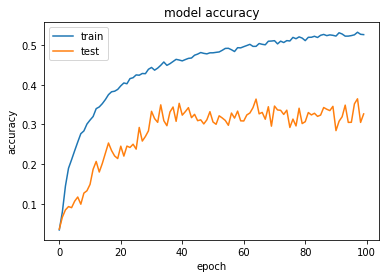

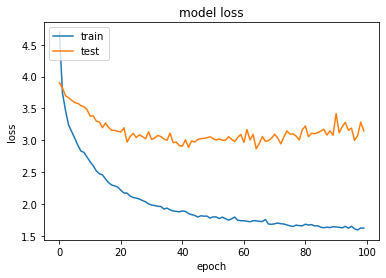

In [44]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

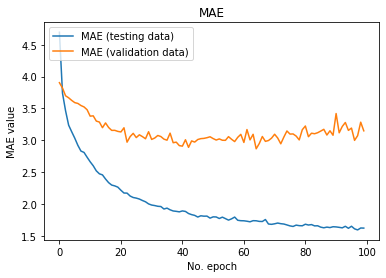

In [45]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

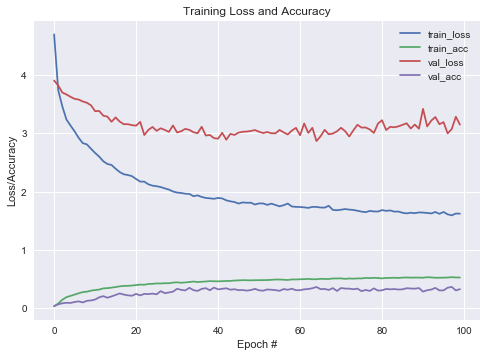

In [46]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochNASNetMobile.png')
plt.close()